## SECTION I. ONE QUOTA CASES

The input in this session looks like this


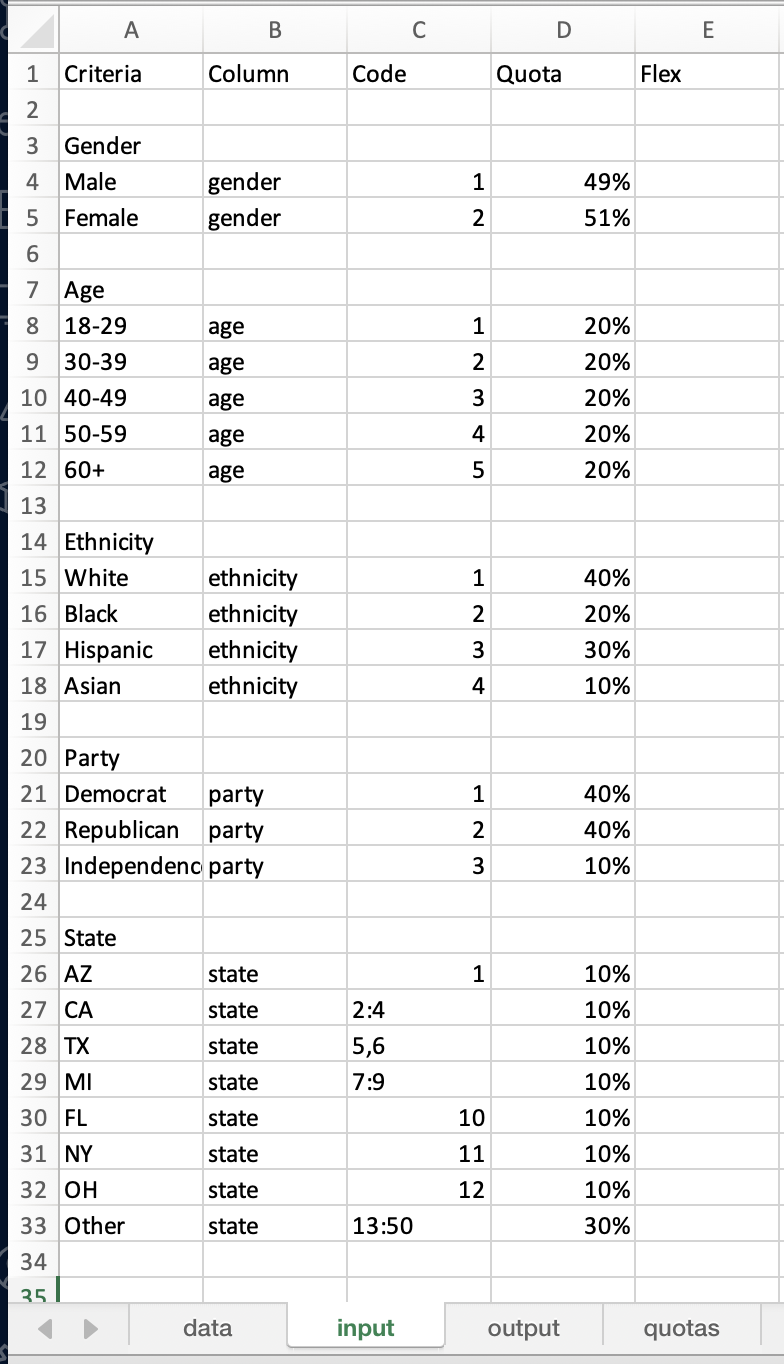

### 1ST USE CASE: 1 SAMPLE - 1 QUOTA

In [8]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import re

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.formatting.rule import FormulaRule


# INPUT SESSION

file_path = r'/Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx'
codesheet = pd.read_excel(file_path, sheet_name='input')
data = pd.read_excel(file_path, sheet_name='data')

configurations = [
    {"sample_col": "Sample", "sample_code": '', "daily_target": 100, "end_target": 250},
    # {"sample_col": "Sample", "sample_code": 2, "daily_target": 100, "end_target": 250},
    # {"sample_col": "Modetype", "sample_code": 3, "daily_target": 40, "end_target": 100},
    # {"sample_col": "Modetype", "sample_code": '', "daily_target": 120, "end_target": 300}
]

one_quota=False # Turn on when tracking many samples but only 1 quota is used across samples. 
quota_name=['Landline', 'Cell'] # 'Text', 'Total'] # Default setting for G2, adjust it as you want but it only gets affected if one_quota is True

flex=0.03

diff_above_col_color = '#c6efce' # Color for conditional formatting of Diff column - fill > flex
diff_above_text_color = '#006100' # Color for conditional formatting of Diff column - text > flex

diff_below_col_color = '#ffc7ce' # Color for conditional formatting of Diff column - fill < flex
diff_below_text_color = '#9c0006' # Color for conditional formatting of Diff column - text < flex

end_diff_col_color = '#ffeb9c' # Color for conditional formatting of End Diff column - fill
end_diff_text_color = '#9c5700'  # Color for conditional formatting of End Diff column - text
print()


# VALIDATION - WARNING IF THE SETUP IS INCORRECT

sample_col = [i["sample_col"] for i in configurations]
sample_code = [i["sample_code"] for i in configurations]
daily_target = [i["daily_target"] for i in configurations]
end_target = [i["end_target"] for i in configurations]

stop=False

if len(daily_target) != len(end_target):
    print("The number of daily_target and end_target must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_col) != len(sample_code):
    print("The number of sample_col and sample_code must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_code)>0 and (len(daily_target) != len(sample_code) or len(end_target) != len(sample_code)):
    print("Length of sample_code does not match daily_target and end_target. If tracking MORE THAN 1 sample, their length must always be the same. Please adjust the script!\n")
    stop=True

if one_quota and (len(sample_col)==0 or len(sample_code)==0):
    print('Only set one_quota=True if there are MORE THAN 1 sample to track. Please adjust the script\n')
    stop=True

if one_quota and (len(quota_name) != len(daily_target) or len(quota_name) != len(end_target) or len(quota_name) != len(sample_code)):
    print("If one_quota=True, length of quota_name must fit daily_target's, end_target's and sample_code's. Please adjust the script\n")
    stop=True

if 'Criteria' not in list(codesheet.columns) or 'Code' not in list(codesheet.columns) or 'Column' not in list(codesheet.columns): 
        print("Can not find 'Criteria', 'Code' or 'Column' column in the input codesheet. Please check the codesheet!\n")
        stop=True  

if not any(i.startswith('Flex') for i in list(codesheet.columns)):
    print("Can not find any 'Flex' column in the input codesheet. Please check the codesheet!\n")
    stop=True

if one_quota==False:
    if len(daily_target)>1 and not any(i.startswith('Quota_') for i in list(codesheet.columns)):
        print('In this case, the quota columns have to start with "Quota_". Please check the codesheet!\n')
        stop=True
    elif len(daily_target)==1 and 'Quota' not in list(codesheet.columns):
        print("Can not find the quota column, it must be 'Quota'. Please check the codesheet!\n")
        stop=True

if one_quota and 'Quota' not in list(codesheet.columns):
    print("It does not seem like there is only one quota to be used. Please check the codesheet!\n")
    stop=True  

quota_col_num = len([c for c in codesheet.columns if c.startswith("Quota")])

if quota_col_num > 1:
    quota_col_name= [i.split("_")[1] for i in codesheet.columns if i.startswith('Quota')]
else:
    quota_col_name = ['']

flex_col_num = len([c for c in codesheet.columns if c.startswith("Flex")])

if flex_col_num > 1:
    flex_col_name = [i.split("_")[1] for i in codesheet.columns if i.startswith('Flex')]
else:
    flex_col_name = [''] 

if quota_col_num == 1 and flex_col_num != 1:
    print("There is only one quota column but multiple flex columns. Please check the codesheet!\n")
    stop=True

if quota_col_num != 1 and flex_col_num != 1 and quota_col_num != flex_col_num:
    print("The number of quota columns does not match the number of flex columns. Please check the codesheet!\n")
    stop=True

if flex_col_num == quota_col_num and set(flex_col_name) != set(quota_col_name):
    print("The names of quota columns do not match the names of flex columns. Please check the codesheet!\n")
    stop=True

j=[]
for i in codesheet['Column']:
    if not pd.isna(i) and i not in list(data.columns):
        j.append(i)
        stop=True    

if j != []:
    print(f"Can not find the column '{', '.join(j)}' in the input data. Please check the codesheet!\n")

def validate_code(value):
    if pd.isna(value):
        return True
    
    val = str(value).strip()
    
    if re.fullmatch(r"\d+", val):
        return True
    
    if re.fullmatch(r"\d+\.0+", val):
        return True
    
    if re.fullmatch(r"\d+:\d+", val):
        return True
    
    if re.fullmatch(r"\d+-\d+", val):
        return True
    
    if re.fullmatch(r"(\d+,)+\d+", val):
        return True
    
    return False

invalid_rows = codesheet[~codesheet['Code'].apply(validate_code)]

if not invalid_rows.empty:
    print("The following Code(s) are invalid. Please check the codesheet!\n")
    print(invalid_rows[['Code']])
    stop=True

if stop:
    raise SystemExit("❌ Program stopped due to validation errors. Please check your input in this code\n")    

print('⌛ Co Tam is working on it! Should be done real quick!\n')


# CLEAN UP THE INPUT CODESHEET

col_order1 = [i for i in codesheet.columns if not i.startswith(('Criteria', 'Code', 'Column', 'Quota', 'Flex'))]
col_order2 = ['Criteria', 'Code', 'Column']
col_order3 = [i for i in codesheet.columns if i.startswith(('Quota'))]
flex_order = [i for i in codesheet.columns if i.startswith(('Flex'))]

codesheet = codesheet.reindex(columns=col_order1 + col_order2 + col_order3 + flex_order)

codesheet['Blankrows'] = 1

for i in range(len(codesheet)-2):
    if pd.isna(codesheet.loc[i, 'Code']) and pd.isna(codesheet.loc[i, 'Column']) and pd.isna(codesheet.loc[i+1, 'Code']) and pd.isna(codesheet.loc[i+1, 'Column']) and pd.isna(codesheet.loc[i+2, 'Code']) and pd.isna(codesheet.loc[i+2, 'Column']):
        codesheet.loc[i, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)
codesheet = codesheet.reset_index(drop=True)

if pd.isna(codesheet.loc[0, 'Criteria']) and pd.isna(codesheet.loc[0, 'Code']) and pd.isna(codesheet.loc[0, 'Column']):
    codesheet.loc[0, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)

codesheet.drop(columns=[col for col in codesheet.columns if col.startswith(('Unnamed', 'Blankrows'))], inplace=True)

if len(col_order1)!=0:
    codesheet.insert(codesheet.columns.get_loc("Criteria"), "", np.nan)
codesheet = codesheet.reset_index(drop=True)


# CREATE THE QUOTA LIST FROM THE INPUT AND THE "quotas" SHEETS FOR BAOLANCER

if len(sample_col) == 1:
    sample_col = sample_col * len(sample_code)

if one_quota==True:
    for i in quota_name:
        codesheet.insert(codesheet.columns.get_loc('Quota'), f'Quota_{i}', codesheet['Quota'])
    codesheet.drop(columns='Quota', inplace=True)    
    quota_list = [f'Quota_{i}' for i in quota_name]
else:    
    quota_list = codesheet.columns[codesheet.columns.str.startswith('Quota')].tolist()

df_quotas = {}

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    df = pd.DataFrame()
    df['Column'] = codesheet['Column']
    df['Quota'] = codesheet[quota_name]
    df['Code'] = codesheet['Code']

    if any("_" in item for item in flex_order):
        df['Flex'] = codesheet[f"Flex{quota_name[quota_name.find('_'):]}"] 
    else:
        df['Flex'] = codesheet['Flex']
    df_quotas[key] = df

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    
    df = df_quotas[key].copy()
    df = df.dropna(subset=['Quota'])  
    df_quotas[key] = df

# ADD FLEX TO THE QUOTA CODESHEET IF IT IS MISSING

for i in flex_order:
    if len(flex_order) == 1:
        codesheet['Flex'] = codesheet['Flex'].fillna(flex)
    else:
        key = i[i.find('_'):]
        codesheet[f'Flex{key}'] = codesheet[f'Flex{key}'].fillna(flex)


# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([empty_rows, codesheet], ignore_index=True)


# INSERT daily (target), NEED, HAVE, PERCENT, DIFF, END NEED, END DIFF, final (target), placerholder COLUMNS. ADJUST THEIR DATA TYPES

for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]
    
    col_idx = codesheet.columns.get_loc(i)

    codesheet.insert(col_idx, f'daily{key}', np.nan)
    codesheet.insert(col_idx+2, f'Need{key}', np.nan)
    codesheet.insert(col_idx+3, f'Have{key}', np.nan)
    codesheet.insert(col_idx+4, f'Percent{key}', np.nan)
    codesheet.insert(col_idx+5, f'Diff{key}', np.nan)
    codesheet.insert(col_idx+6, f'End Need{key}', np.nan)
    codesheet.insert(col_idx+7, f'End Diff{key}', np.nan)
    codesheet.insert(col_idx+8, f'final{key}', np.nan)
    codesheet.insert(col_idx+9, f'placeholder{key}', np.nan)

j=0
for i in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    codesheet.loc[0, f'Need{key}'] = daily_target[j] 
    codesheet.loc[0, f'End Need{key}'] = end_target[j] 
    j += 1

    if one_quota==True:
        codesheet['Quota']=codesheet[f'Quota{key}']
        col_list=list(codesheet.columns)
        col_list.remove('Quota')
        col_list.insert(codesheet.columns.get_loc('Code'), 'Quota')
        codesheet=codesheet[col_list]    

for i in codesheet.columns:
    codesheet[i] = codesheet[i].astype('object')


# CREATE THE CLEANED HEADER ROWS FOR THE CODESHEET

for i in codesheet.columns:
    if i in ['Criteria', 'Code', 'Quota', 'Need', 'Have', 'Percent', 'Diff', 'End Need', 'End Diff'] or i in col_order1:
        codesheet.loc[1, i] = i
    elif i.startswith(('Quota_', 'Need_', 'Have_', 'Percent_', 'Diff_', 'End Need_', 'End Diff_')):
        codesheet.loc[1, i] = i.split('_')[0]

    if i.startswith('Have'):
        codesheet.loc[0, i] = i.split('_')[1] if '_' in i else ''    

# CREATE FUNCTIONS

# Convert column index in Python to column name in Excel
def index_to_excel_column(n):
    result = ''
    while n >= 0:
        result = chr(n % 26 + ord('A')) + result
        n = n // 26 - 1
    return result.upper()

# Generate list of codes from the "Code" column
def define_code(code):
    if str(code).__contains__(":"):
        range_part = str(code).replace("'", "").split(':')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    elif str(code).__contains__("-"):
        range_part = str(code).replace("'", "").split('-')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    else:    
        list_code = str(code).split(',')

    return list_code

# DROP DAILY TARGET AND FINAL TARGET COLUMNS
# These columns are not needed but because they affect the structure of the codesheet, they are created first and then dropped at the end.
codesheet = codesheet.drop(
    columns=[c for c in codesheet.columns if c.startswith("daily") or c.startswith("final")]
)

# GET THE COLUMN NAMES OF REFERRED COLUMNS TO USE IN THE FORMULAS

col_locs = {}
for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    if one_quota==True:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc('Quota'))
        codesheet.drop(columns=i, inplace=True)
    else:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(i))    
    
    col_locs[f'Need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Need{key}'))
    col_locs[f'have{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Have{key}'))
    col_locs[f'percent{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Percent{key}'))
    col_locs[f'diff{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Diff{key}'))
    col_locs[f'end_need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'End Need{key}'))

    
code_loc=index_to_excel_column(codesheet.columns.get_loc('Code'))

sample_loc=[]
if len(sample_col)>0:
    for i in range(len(sample_col)):
        sample_loc.append(index_to_excel_column(data.columns.get_loc(sample_col[i])))

# CREATE THE FORMULAS

# One sample
if len(quota_list)==1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):

            key = ''

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')

                list_code = define_code(codesheet.loc[i, 'Code'])

                col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = (f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})')
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (f'COUNTIFS(data!${col_excel}:${col_excel},{list_code[x]})')
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})'
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (
                            f"COUNTIFS(data!${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))}:"
                            f"${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))},{list_code[x]})"
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
            
            if (not pd.isna(codesheet.loc[i, f'Quota{key}'])) and (codesheet.loc[i, f'Quota{key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f'={percent_col}{i+2}-{quota_col}{i+2}'
                codesheet.loc[i, f'End Need{key}'] = f'={quota_col}{i+2}*{end_need_col}$2'
                codesheet.loc[i, f'End Diff{key}'] = f'={end_need_col}{i+2}-{have_col}{i+2}'

        a += 1

# More than one samples
if len(quota_list)>1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):
            
            key = j[j.find('_'):]

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')
                
                list_code = define_code(codesheet.loc[i, 'Code'])

                if sample_code[a-1] == '':
                    if len(list_code) == 1:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        codesheet.loc[i, f'Have{key}'] = f"=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})"
                    else:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        Have_formula_part = '=' + '+'.join(
                            [f"COUNTIFS(data!${col_excel}:${col_excel},{code})" for code in list_code]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
                else:
                    col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                    if len(list_code) == 1:
                        codesheet.loc[i, f'Have{key}'] = (
                            f"=COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                            f"data!${col_excel}:${col_excel},${code_loc}{i+2})"
                        )
                    else:
                        Have_formula_part = '=' + '+'.join(
                            [
                                f"COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                                f"data!${col_excel}:${col_excel},{code})"
                                for code in list_code
                            ]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

            if one_quota==True:
                quota_col_key = ''
            else:
                quota_col_key = key

            if (not pd.isna(codesheet.loc[i, f'Quota{quota_col_key}'])) and (codesheet.loc[i, f'Quota{quota_col_key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f"={percent_col}{i+2}-{quota_col}{i+2}"
                codesheet.loc[i, f'End Need{key}'] = f"={quota_col}{i+2}*{end_need_col}$2"
                codesheet.loc[i, f'End Diff{key}'] = f"={end_need_col}{i+2}-{have_col}{i+2}"
    
        a += 1    

# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([codesheet, empty_rows], ignore_index=True)


# CREATE FORMULA TO CALCULATE SUM

a=0
b=0
for j in quota_list:
    for i in range(1, len(codesheet)-1):
       
        if len(quota_list) == 1:
            ''
        else:
            key = j[j.find('_'):]

        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i-1, f'Have{key}']):
            a=i+2
        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i+1, f'Have{key}']):
            b=i+2

        if pd.isna(codesheet.loc[i, f'Have{key}']) and pd.isna(codesheet.loc[i+1, f'Have{key}']):
            have_col = col_locs[f"have{key}_loc"]
            codesheet.loc[i, f"Have{key}"] = f"=SUM({have_col}{a}:{have_col}{b})"

    for i in range(len(codesheet)-1):
        if pd.isna(codesheet['Code'][i]) & (not pd.isna(codesheet['Code'][i+1])):
            codesheet.loc[i, 'Code'] = codesheet.loc[i + 1, 'Column']
        codesheet.loc[i, 'Column']=np.nan    


# CREATE TWO LISTS OF ROWS TO STORE THE POSITION OF ROWS THAT NEED BOLD FORMATTING & CONDITIONAL FORMATTING

bold_dict = {}  
conditional_formatting_dict = {}

for j in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = j[j.find('_'):]
    
    bold_dict[j] = [0, 1]
    conditional_formatting_dict[j] = []

    for i in range(len(codesheet)):
  
        if ((not pd.isna(codesheet.loc[i, 'Criteria'])) & (not pd.isna(codesheet.loc[i, 'Code'])) & (pd.isna(codesheet.loc[i, f'Have{key}']))) or ((pd.isna(codesheet.loc[i, 'Criteria'])) & (pd.isna(codesheet.loc[i, 'Code'])) & (not pd.isna(codesheet.loc[i, f'Have{key}']))):
            bold_dict[j].append(i)

        if (not pd.isna(codesheet.loc[i, f'Diff{key}'])):
            conditional_formatting_dict[j].append(i)


# DROP UNNECESSARY COLUMNS

new_columns = []

for col in codesheet.columns:
    if col == 'Column' or col.startswith(('placeholder', 'daily', 'final')):
        new_columns.append("")
    elif one_quota & col.startswith('Quota_'):
        codesheet[col]=np.nan
        new_columns.append("")
    else:
        new_columns.append(col)

codesheet.columns = new_columns


# WRITE THE PROCESSED CODESHEET AND THE 'quotas' TABS IN THE ORIGINAL FILE

flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]
codesheet_to_save = codesheet.drop(columns=flex_cols)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    codesheet_to_save.to_excel(writer, sheet_name='output', index=False, header=False, startrow=1)

    for quota_name in quota_list:
        if len(quota_list) == 1:
            key = ''
        else:
            key = quota_name[quota_name.find('_'):]
        if one_quota==True:
            df_quotas[key].to_excel(writer, sheet_name='quotas', index=False, header=True, startrow=0)
        else:    
            df_quotas[key].to_excel(writer, sheet_name=f'quotas{key.replace("_","")}', index=False, header=True, startrow=0)


# FORMAT THE CODESHEET

wb = load_workbook(file_path)
ws = wb['output']

# Style
bold_center = Alignment(horizontal='center', vertical='center')
bold_font = Font(bold=True)
center_alignment = Alignment(horizontal='center', vertical='center')
left_alignment = Alignment(horizontal='left', vertical='center')


# Header formatting
header_names = list(codesheet_to_save.columns)
for col_idx, col_name in enumerate(header_names, 1):
    cell = ws.cell(row=1, column=col_idx, value=col_name)
    # cell.font = bold_font
    cell.alignment = bold_center

# Percentage formatting
percent_cols = [i for i in list(codesheet.columns) if i.startswith('Quota') or  i.startswith('Percent') or i.startswith('Diff')]

col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}
criteria_col_index = col_indices.get('Criteria', None)

for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        if header_names[cell.column - 1] in percent_cols:
            cell.number_format = '0%'

        if cell.column != criteria_col_index:
            cell.alignment = center_alignment   

# Bold formatting
for quota_name_x, rows_list in bold_dict.items():
    for df_row in rows_list:
        excel_row = df_row + 2 
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=excel_row, column=col)
            cell.font = bold_font
            if cell.column != criteria_col_index:
                cell.alignment = center_alignment


# Round formatting
round_cols = [i for i in list(codesheet.columns) if i.startswith('Need') or  i.startswith('End Need') or i.startswith('End Diff')]
col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}

for col_name in round_cols:
    col_index = col_indices.get(col_name)

    for row in range(2, ws.max_row + 1): 
        cell = ws.cell(row=row, column=col_index)
        cell.number_format = '0' 


# Conditional formatting
fill_above_diff = PatternFill(start_color=diff_above_col_color.replace('#',''), end_color=diff_above_col_color.replace('#',''), fill_type='solid')
font_above_diff = Font(color=diff_above_text_color.replace('#', ''))

fill_below_diff = PatternFill(start_color=diff_below_col_color.replace('#',''), end_color=diff_below_col_color.replace('#',''), fill_type='solid')
font_below_diff = Font(color=diff_below_text_color.replace('#', ''))

fill_end_diff = PatternFill(start_color=end_diff_col_color.replace('#',''), end_color=end_diff_col_color.replace('#',''), fill_type='solid')
font_end_diff = Font(color=end_diff_text_color.replace('#', ''))


flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]

for col in codesheet.columns:
    if col.startswith("Diff") and not col.startswith("End Diff"):
        diff_col_index = col_indices.get(col)
        if diff_col_index:
            col_letter = ws.cell(row=2, column=diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                if len(flex_cols) == 1:
                    flex_value = codesheet.loc[row-2, flex_cols[0]]
                else:
                    suffix = col[len("Diff"):]
                    flex_col = f"Flex{suffix}"
                    flex_value = codesheet.loc[row-2, flex_col]

                if pd.isna(flex_value):
                    continue

                cell = f"{col_letter}{row}"

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < {-float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_below_diff,
                        font=font_below_diff
                    )
                )

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} > {float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_above_diff,
                        font=font_above_diff
                    )
                )

    elif col.startswith("End Diff"):
        end_diff_col_index = col_indices.get(col)
        if end_diff_col_index:
            col_letter = ws.cell(row=2, column=end_diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                cell = f"{col_letter}{row}"
                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < 0)'],
                        stopIfTrue=True,
                        fill=fill_end_diff,
                        font=font_end_diff
                    )
                )

# Color the second row
orange_fill = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=2, column=col)
    cell.fill = orange_fill


# Highlight daily target and final target
highlight_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid") 

for col_name, col_index in col_indices.items():
    if col_name.startswith("Need") or col_name.startswith("End Need"):
        cell = ws.cell(row=2, column=col_index)
        cell.fill = highlight_fill

wb.save(file_path)

print(f"✅ Co Tam has finished! 'output' has been added to the data file {file_path}")



⌛ Co Tam is working on it! Should be done real quick!

✅ Co Tam has finished! 'output' has been added to the data file /Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx


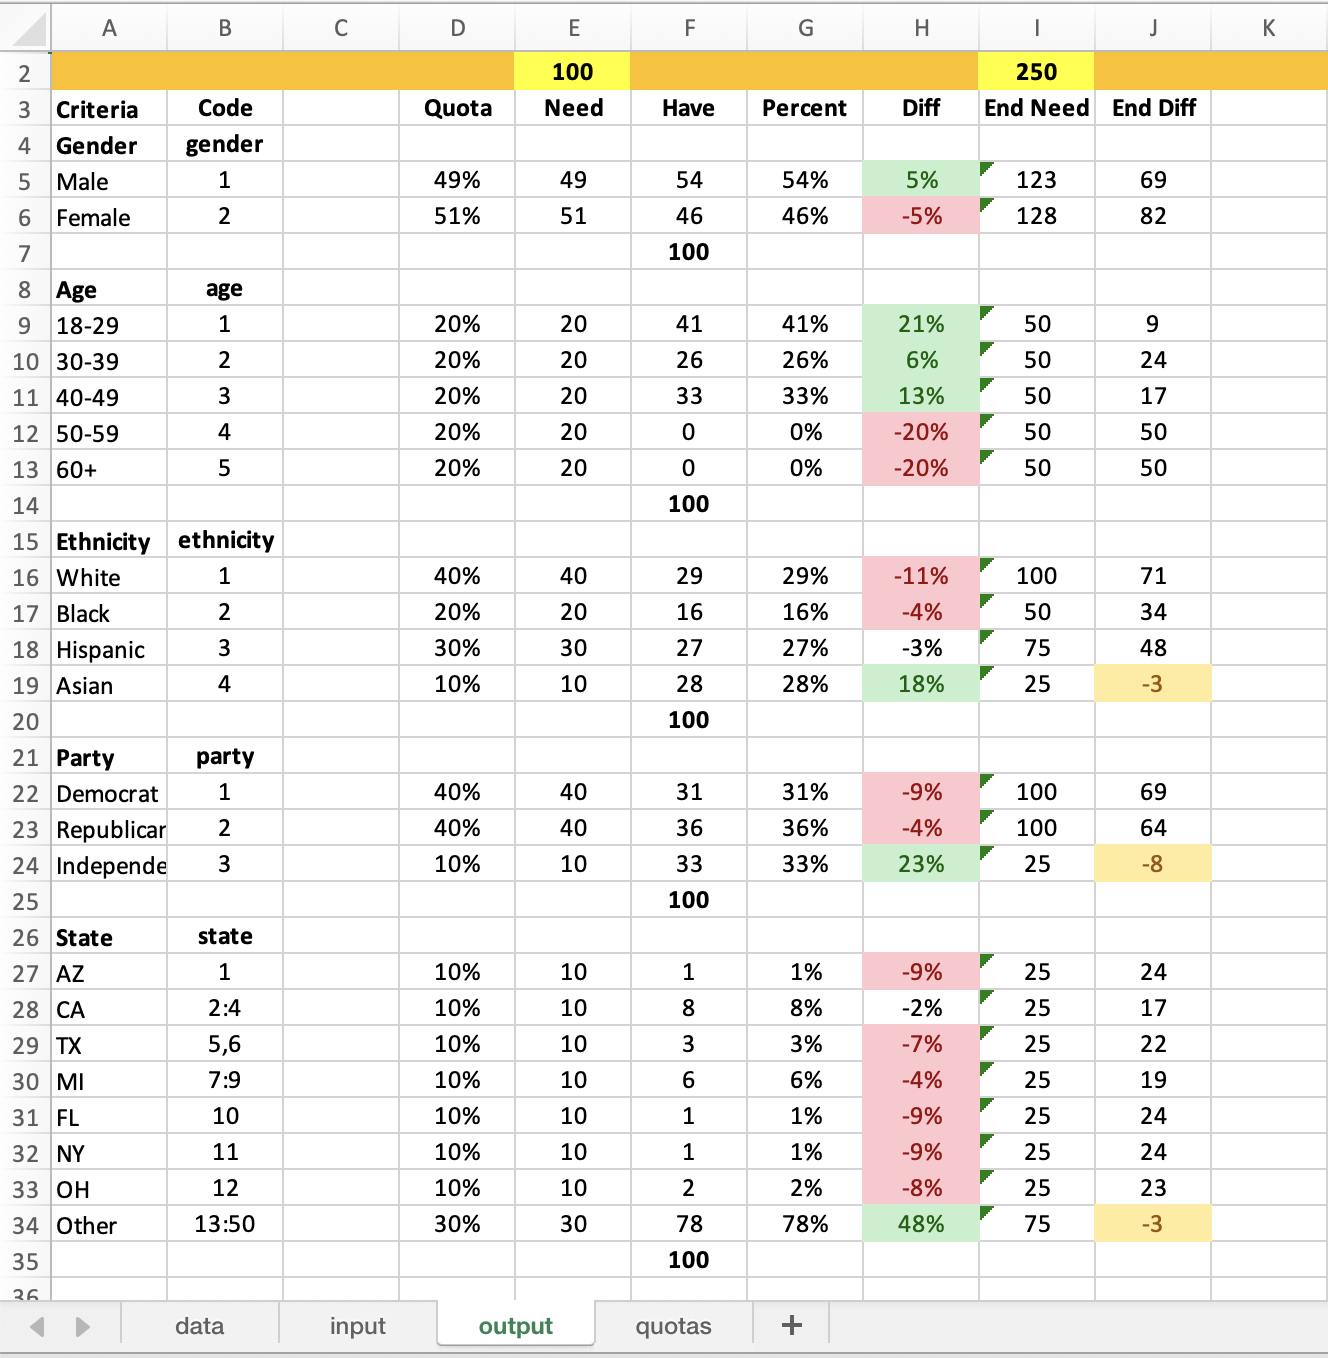

### 2ND USE CASE: MANY SAMPLES - 1 QUOTA

In [9]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import re

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.formatting.rule import FormulaRule


# INPUT SESSION

file_path = r'/Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx'
codesheet = pd.read_excel(file_path, sheet_name='input')
data = pd.read_excel(file_path, sheet_name='data')

configurations = [
    {"sample_col": "Sample", "sample_code": 1, "daily_target": 100, "end_target": 250},
    {"sample_col": "Sample", "sample_code": 2, "daily_target": 100, "end_target": 250},
    # {"sample_col": "Modetype", "sample_code": 3, "daily_target": 40, "end_target": 100},
    # {"sample_col": "Modetype", "sample_code": '', "daily_target": 120, "end_target": 300}
]

one_quota=True # Turn on when tracking many samples but only 1 quota is used across samples. 
quota_name=['Landline', 'Cell'] # 'Text', 'Total'] # Default setting for G2, adjust it as you want but it only gets affected if one_quota is True

flex=0.03

diff_above_col_color = '#c6efce' # Color for conditional formatting of Diff column - fill > flex
diff_above_text_color = '#006100' # Color for conditional formatting of Diff column - text > flex

diff_below_col_color = '#ffc7ce' # Color for conditional formatting of Diff column - fill < flex
diff_below_text_color = '#9c0006' # Color for conditional formatting of Diff column - text < flex

end_diff_col_color = '#ffeb9c' # Color for conditional formatting of End Diff column - fill
end_diff_text_color = '#9c5700'  # Color for conditional formatting of End Diff column - text
print()


# VALIDATION - WARNING IF THE SETUP IS INCORRECT

sample_col = [i["sample_col"] for i in configurations]
sample_code = [i["sample_code"] for i in configurations]
daily_target = [i["daily_target"] for i in configurations]
end_target = [i["end_target"] for i in configurations]

stop=False

if len(daily_target) != len(end_target):
    print("The number of daily_target and end_target must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_col) != len(sample_code):
    print("The number of sample_col and sample_code must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_code)>0 and (len(daily_target) != len(sample_code) or len(end_target) != len(sample_code)):
    print("Length of sample_code does not match daily_target and end_target. If tracking MORE THAN 1 sample, their length must always be the same. Please adjust the script!\n")
    stop=True

if one_quota and (len(sample_col)==0 or len(sample_code)==0):
    print('Only set one_quota=True if there are MORE THAN 1 sample to track. Please adjust the script\n')
    stop=True

if one_quota and (len(quota_name) != len(daily_target) or len(quota_name) != len(end_target) or len(quota_name) != len(sample_code)):
    print("If one_quota=True, length of quota_name must fit daily_target's, end_target's and sample_code's. Please adjust the script\n")
    stop=True

if 'Criteria' not in list(codesheet.columns) or 'Code' not in list(codesheet.columns) or 'Column' not in list(codesheet.columns): 
        print("Can not find 'Criteria', 'Code' or 'Column' column in the input codesheet. Please check the codesheet!\n")
        stop=True  

if not any(i.startswith('Flex') for i in list(codesheet.columns)):
    print("Can not find any 'Flex' column in the input codesheet. Please check the codesheet!\n")
    stop=True

if one_quota==False:
    if len(daily_target)>1 and not any(i.startswith('Quota_') for i in list(codesheet.columns)):
        print('In this case, the quota columns have to start with "Quota_". Please check the codesheet!\n')
        stop=True
    elif len(daily_target)==1 and 'Quota' not in list(codesheet.columns):
        print("Can not find the quota column, it must be 'Quota'. Please check the codesheet!\n")
        stop=True

if one_quota and 'Quota' not in list(codesheet.columns):
    print("It does not seem like there is only one quota to be used. Please check the codesheet!\n")
    stop=True  

quota_col_num = len([c for c in codesheet.columns if c.startswith("Quota")])

if quota_col_num > 1:
    quota_col_name= [i.split("_")[1] for i in codesheet.columns if i.startswith('Quota')]
else:
    quota_col_name = ['']

flex_col_num = len([c for c in codesheet.columns if c.startswith("Flex")])

if flex_col_num > 1:
    flex_col_name = [i.split("_")[1] for i in codesheet.columns if i.startswith('Flex')]
else:
    flex_col_name = [''] 

if quota_col_num == 1 and flex_col_num != 1:
    print("There is only one quota column but multiple flex columns. Please check the codesheet!\n")
    stop=True

if quota_col_num != 1 and flex_col_num != 1 and quota_col_num != flex_col_num:
    print("The number of quota columns does not match the number of flex columns. Please check the codesheet!\n")
    stop=True

if flex_col_num == quota_col_num and set(flex_col_name) != set(quota_col_name):
    print("The names of quota columns do not match the names of flex columns. Please check the codesheet!\n")
    stop=True

j=[]
for i in codesheet['Column']:
    if not pd.isna(i) and i not in list(data.columns):
        j.append(i)
        stop=True    

if j != []:
    print(f"Can not find the column '{', '.join(j)}' in the input data. Please check the codesheet!\n")

def validate_code(value):
    if pd.isna(value):
        return True
    
    val = str(value).strip()
    
    if re.fullmatch(r"\d+", val):
        return True
    
    if re.fullmatch(r"\d+\.0+", val):
        return True
    
    if re.fullmatch(r"\d+:\d+", val):
        return True
    
    if re.fullmatch(r"\d+-\d+", val):
        return True
    
    if re.fullmatch(r"(\d+,)+\d+", val):
        return True
    
    return False

invalid_rows = codesheet[~codesheet['Code'].apply(validate_code)]

if not invalid_rows.empty:
    print("The following Code(s) are invalid. Please check the codesheet!\n")
    print(invalid_rows[['Code']])
    stop=True

if stop:
    raise SystemExit("❌ Program stopped due to validation errors. Please check your input in this code\n")    

print('⌛ Co Tam is working on it! Should be done real quick!\n')


# CLEAN UP THE INPUT CODESHEET

col_order1 = [i for i in codesheet.columns if not i.startswith(('Criteria', 'Code', 'Column', 'Quota', 'Flex'))]
col_order2 = ['Criteria', 'Code', 'Column']
col_order3 = [i for i in codesheet.columns if i.startswith(('Quota'))]
flex_order = [i for i in codesheet.columns if i.startswith(('Flex'))]

codesheet = codesheet.reindex(columns=col_order1 + col_order2 + col_order3 + flex_order)

codesheet['Blankrows'] = 1

for i in range(len(codesheet)-2):
    if pd.isna(codesheet.loc[i, 'Code']) and pd.isna(codesheet.loc[i, 'Column']) and pd.isna(codesheet.loc[i+1, 'Code']) and pd.isna(codesheet.loc[i+1, 'Column']) and pd.isna(codesheet.loc[i+2, 'Code']) and pd.isna(codesheet.loc[i+2, 'Column']):
        codesheet.loc[i, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)
codesheet = codesheet.reset_index(drop=True)

if pd.isna(codesheet.loc[0, 'Criteria']) and pd.isna(codesheet.loc[0, 'Code']) and pd.isna(codesheet.loc[0, 'Column']):
    codesheet.loc[0, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)

codesheet.drop(columns=[col for col in codesheet.columns if col.startswith(('Unnamed', 'Blankrows'))], inplace=True)

if len(col_order1)!=0:
    codesheet.insert(codesheet.columns.get_loc("Criteria"), "", np.nan)
codesheet = codesheet.reset_index(drop=True)


# CREATE THE QUOTA LIST FROM THE INPUT AND THE "quotas" SHEETS FOR BAOLANCER

if len(sample_col) == 1:
    sample_col = sample_col * len(sample_code)

if one_quota==True:
    for i in quota_name:
        codesheet.insert(codesheet.columns.get_loc('Quota'), f'Quota_{i}', codesheet['Quota'])
    codesheet.drop(columns='Quota', inplace=True)    
    quota_list = [f'Quota_{i}' for i in quota_name]
else:    
    quota_list = codesheet.columns[codesheet.columns.str.startswith('Quota')].tolist()

df_quotas = {}

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    df = pd.DataFrame()
    df['Column'] = codesheet['Column']
    df['Quota'] = codesheet[quota_name]
    df['Code'] = codesheet['Code']

    if any("_" in item for item in flex_order):
        df['Flex'] = codesheet[f"Flex{quota_name[quota_name.find('_'):]}"] 
    else:
        df['Flex'] = codesheet['Flex']
    df_quotas[key] = df

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    
    df = df_quotas[key].copy()
    df = df.dropna(subset=['Quota'])  
    df_quotas[key] = df

# ADD FLEX TO THE QUOTA CODESHEET IF IT IS MISSING

for i in flex_order:
    if len(flex_order) == 1:
        codesheet['Flex'] = codesheet['Flex'].fillna(flex)
    else:
        key = i[i.find('_'):]
        codesheet[f'Flex{key}'] = codesheet[f'Flex{key}'].fillna(flex)


# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([empty_rows, codesheet], ignore_index=True)


# INSERT daily (target), NEED, HAVE, PERCENT, DIFF, END NEED, END DIFF, final (target), placerholder COLUMNS. ADJUST THEIR DATA TYPES

for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]
    
    col_idx = codesheet.columns.get_loc(i)

    codesheet.insert(col_idx, f'daily{key}', np.nan)
    codesheet.insert(col_idx+2, f'Need{key}', np.nan)
    codesheet.insert(col_idx+3, f'Have{key}', np.nan)
    codesheet.insert(col_idx+4, f'Percent{key}', np.nan)
    codesheet.insert(col_idx+5, f'Diff{key}', np.nan)
    codesheet.insert(col_idx+6, f'End Need{key}', np.nan)
    codesheet.insert(col_idx+7, f'End Diff{key}', np.nan)
    codesheet.insert(col_idx+8, f'final{key}', np.nan)
    codesheet.insert(col_idx+9, f'placeholder{key}', np.nan)

j=0
for i in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    codesheet.loc[0, f'Need{key}'] = daily_target[j] 
    codesheet.loc[0, f'End Need{key}'] = end_target[j] 
    j += 1

    if one_quota==True:
        codesheet['Quota']=codesheet[f'Quota{key}']
        col_list=list(codesheet.columns)
        col_list.remove('Quota')
        col_list.insert(codesheet.columns.get_loc('Code'), 'Quota')
        codesheet=codesheet[col_list]    

for i in codesheet.columns:
    codesheet[i] = codesheet[i].astype('object')


# CREATE THE CLEANED HEADER ROWS FOR THE CODESHEET

for i in codesheet.columns:
    if i in ['Criteria', 'Code', 'Quota', 'Need', 'Have', 'Percent', 'Diff', 'End Need', 'End Diff'] or i in col_order1:
        codesheet.loc[1, i] = i
    elif i.startswith(('Quota_', 'Need_', 'Have_', 'Percent_', 'Diff_', 'End Need_', 'End Diff_')):
        codesheet.loc[1, i] = i.split('_')[0]

    if i.startswith('Have'):
        codesheet.loc[0, i] = i.split('_')[1] if '_' in i else ''    

# CREATE FUNCTIONS

# Convert column index in Python to column name in Excel
def index_to_excel_column(n):
    result = ''
    while n >= 0:
        result = chr(n % 26 + ord('A')) + result
        n = n // 26 - 1
    return result.upper()

# Generate list of codes from the "Code" column
def define_code(code):
    if str(code).__contains__(":"):
        range_part = str(code).replace("'", "").split(':')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    elif str(code).__contains__("-"):
        range_part = str(code).replace("'", "").split('-')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    else:    
        list_code = str(code).split(',')

    return list_code

# DROP DAILY TARGET AND FINAL TARGET COLUMNS
# These columns are not needed but because they affect the structure of the codesheet, they are created first and then dropped at the end.
codesheet = codesheet.drop(
    columns=[c for c in codesheet.columns if c.startswith("daily") or c.startswith("final")]
)

# GET THE COLUMN NAMES OF REFERRED COLUMNS TO USE IN THE FORMULAS

col_locs = {}
for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    if one_quota==True:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc('Quota'))
        codesheet.drop(columns=i, inplace=True)
    else:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(i))    
    
    col_locs[f'Need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Need{key}'))
    col_locs[f'have{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Have{key}'))
    col_locs[f'percent{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Percent{key}'))
    col_locs[f'diff{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Diff{key}'))
    col_locs[f'end_need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'End Need{key}'))

    
code_loc=index_to_excel_column(codesheet.columns.get_loc('Code'))

sample_loc=[]
if len(sample_col)>0:
    for i in range(len(sample_col)):
        sample_loc.append(index_to_excel_column(data.columns.get_loc(sample_col[i])))

# CREATE THE FORMULAS

# One sample
if len(quota_list)==1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):

            key = ''

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')

                list_code = define_code(codesheet.loc[i, 'Code'])

                col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = (f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})')
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (f'COUNTIFS(data!${col_excel}:${col_excel},{list_code[x]})')
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})'
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (
                            f"COUNTIFS(data!${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))}:"
                            f"${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))},{list_code[x]})"
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
            
            if (not pd.isna(codesheet.loc[i, f'Quota{key}'])) and (codesheet.loc[i, f'Quota{key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f'={percent_col}{i+2}-{quota_col}{i+2}'
                codesheet.loc[i, f'End Need{key}'] = f'={quota_col}{i+2}*{end_need_col}$2'
                codesheet.loc[i, f'End Diff{key}'] = f'={end_need_col}{i+2}-{have_col}{i+2}'

        a += 1

# More than one samples
if len(quota_list)>1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):
            
            key = j[j.find('_'):]

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')
                
                list_code = define_code(codesheet.loc[i, 'Code'])

                if sample_code[a-1] == '':
                    if len(list_code) == 1:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        codesheet.loc[i, f'Have{key}'] = f"=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})"
                    else:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        Have_formula_part = '=' + '+'.join(
                            [f"COUNTIFS(data!${col_excel}:${col_excel},{code})" for code in list_code]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
                else:
                    col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                    if len(list_code) == 1:
                        codesheet.loc[i, f'Have{key}'] = (
                            f"=COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                            f"data!${col_excel}:${col_excel},${code_loc}{i+2})"
                        )
                    else:
                        Have_formula_part = '=' + '+'.join(
                            [
                                f"COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                                f"data!${col_excel}:${col_excel},{code})"
                                for code in list_code
                            ]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

            if one_quota==True:
                quota_col_key = ''
            else:
                quota_col_key = key

            if (not pd.isna(codesheet.loc[i, f'Quota{quota_col_key}'])) and (codesheet.loc[i, f'Quota{quota_col_key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f"={percent_col}{i+2}-{quota_col}{i+2}"
                codesheet.loc[i, f'End Need{key}'] = f"={quota_col}{i+2}*{end_need_col}$2"
                codesheet.loc[i, f'End Diff{key}'] = f"={end_need_col}{i+2}-{have_col}{i+2}"
    
        a += 1    

# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([codesheet, empty_rows], ignore_index=True)


# CREATE FORMULA TO CALCULATE SUM

a=0
b=0
for j in quota_list:
    for i in range(1, len(codesheet)-1):
       
        if len(quota_list) == 1:
            ''
        else:
            key = j[j.find('_'):]

        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i-1, f'Have{key}']):
            a=i+2
        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i+1, f'Have{key}']):
            b=i+2

        if pd.isna(codesheet.loc[i, f'Have{key}']) and pd.isna(codesheet.loc[i+1, f'Have{key}']):
            have_col = col_locs[f"have{key}_loc"]
            codesheet.loc[i, f"Have{key}"] = f"=SUM({have_col}{a}:{have_col}{b})"

    for i in range(len(codesheet)-1):
        if pd.isna(codesheet['Code'][i]) & (not pd.isna(codesheet['Code'][i+1])):
            codesheet.loc[i, 'Code'] = codesheet.loc[i + 1, 'Column']
        codesheet.loc[i, 'Column']=np.nan    


# CREATE TWO LISTS OF ROWS TO STORE THE POSITION OF ROWS THAT NEED BOLD FORMATTING & CONDITIONAL FORMATTING

bold_dict = {}  
conditional_formatting_dict = {}

for j in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = j[j.find('_'):]
    
    bold_dict[j] = [0, 1]
    conditional_formatting_dict[j] = []

    for i in range(len(codesheet)):
  
        if ((not pd.isna(codesheet.loc[i, 'Criteria'])) & (not pd.isna(codesheet.loc[i, 'Code'])) & (pd.isna(codesheet.loc[i, f'Have{key}']))) or ((pd.isna(codesheet.loc[i, 'Criteria'])) & (pd.isna(codesheet.loc[i, 'Code'])) & (not pd.isna(codesheet.loc[i, f'Have{key}']))):
            bold_dict[j].append(i)

        if (not pd.isna(codesheet.loc[i, f'Diff{key}'])):
            conditional_formatting_dict[j].append(i)


# DROP UNNECESSARY COLUMNS

new_columns = []

for col in codesheet.columns:
    if col == 'Column' or col.startswith(('placeholder', 'daily', 'final')):
        new_columns.append("")
    elif one_quota & col.startswith('Quota_'):
        codesheet[col]=np.nan
        new_columns.append("")
    else:
        new_columns.append(col)

codesheet.columns = new_columns


# WRITE THE PROCESSED CODESHEET AND THE 'quotas' TABS IN THE ORIGINAL FILE

flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]
codesheet_to_save = codesheet.drop(columns=flex_cols)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    codesheet_to_save.to_excel(writer, sheet_name='output', index=False, header=False, startrow=1)

    for quota_name in quota_list:
        if len(quota_list) == 1:
            key = ''
        else:
            key = quota_name[quota_name.find('_'):]
        if one_quota==True:
            df_quotas[key].to_excel(writer, sheet_name='quotas', index=False, header=True, startrow=0)
        else:    
            df_quotas[key].to_excel(writer, sheet_name=f'quotas{key.replace("_","")}', index=False, header=True, startrow=0)


# FORMAT THE CODESHEET

wb = load_workbook(file_path)
ws = wb['output']

# Style
bold_center = Alignment(horizontal='center', vertical='center')
bold_font = Font(bold=True)
center_alignment = Alignment(horizontal='center', vertical='center')
left_alignment = Alignment(horizontal='left', vertical='center')


# Header formatting
header_names = list(codesheet_to_save.columns)
for col_idx, col_name in enumerate(header_names, 1):
    cell = ws.cell(row=1, column=col_idx, value=col_name)
    # cell.font = bold_font
    cell.alignment = bold_center

# Percentage formatting
percent_cols = [i for i in list(codesheet.columns) if i.startswith('Quota') or  i.startswith('Percent') or i.startswith('Diff')]

col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}
criteria_col_index = col_indices.get('Criteria', None)

for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        if header_names[cell.column - 1] in percent_cols:
            cell.number_format = '0%'

        if cell.column != criteria_col_index:
            cell.alignment = center_alignment   

# Bold formatting
for quota_name_x, rows_list in bold_dict.items():
    for df_row in rows_list:
        excel_row = df_row + 2 
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=excel_row, column=col)
            cell.font = bold_font
            if cell.column != criteria_col_index:
                cell.alignment = center_alignment


# Round formatting
round_cols = [i for i in list(codesheet.columns) if i.startswith('Need') or  i.startswith('End Need') or i.startswith('End Diff')]
col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}

for col_name in round_cols:
    col_index = col_indices.get(col_name)

    for row in range(2, ws.max_row + 1): 
        cell = ws.cell(row=row, column=col_index)
        cell.number_format = '0' 


# Conditional formatting
fill_above_diff = PatternFill(start_color=diff_above_col_color.replace('#',''), end_color=diff_above_col_color.replace('#',''), fill_type='solid')
font_above_diff = Font(color=diff_above_text_color.replace('#', ''))

fill_below_diff = PatternFill(start_color=diff_below_col_color.replace('#',''), end_color=diff_below_col_color.replace('#',''), fill_type='solid')
font_below_diff = Font(color=diff_below_text_color.replace('#', ''))

fill_end_diff = PatternFill(start_color=end_diff_col_color.replace('#',''), end_color=end_diff_col_color.replace('#',''), fill_type='solid')
font_end_diff = Font(color=end_diff_text_color.replace('#', ''))


flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]

for col in codesheet.columns:
    if col.startswith("Diff") and not col.startswith("End Diff"):
        diff_col_index = col_indices.get(col)
        if diff_col_index:
            col_letter = ws.cell(row=2, column=diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                if len(flex_cols) == 1:
                    flex_value = codesheet.loc[row-2, flex_cols[0]]
                else:
                    suffix = col[len("Diff"):]
                    flex_col = f"Flex{suffix}"
                    flex_value = codesheet.loc[row-2, flex_col]

                if pd.isna(flex_value):
                    continue

                cell = f"{col_letter}{row}"

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < {-float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_below_diff,
                        font=font_below_diff
                    )
                )

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} > {float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_above_diff,
                        font=font_above_diff
                    )
                )

    elif col.startswith("End Diff"):
        end_diff_col_index = col_indices.get(col)
        if end_diff_col_index:
            col_letter = ws.cell(row=2, column=end_diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                cell = f"{col_letter}{row}"
                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < 0)'],
                        stopIfTrue=True,
                        fill=fill_end_diff,
                        font=font_end_diff
                    )
                )

# Color the second row
orange_fill = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=2, column=col)
    cell.fill = orange_fill


# Highlight daily target and final target
highlight_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid") 

for col_name, col_index in col_indices.items():
    if col_name.startswith("Need") or col_name.startswith("End Need"):
        cell = ws.cell(row=2, column=col_index)
        cell.fill = highlight_fill

wb.save(file_path)

print(f"✅ Co Tam has finished! 'output' has been added to the data file {file_path}")



⌛ Co Tam is working on it! Should be done real quick!

✅ Co Tam has finished! 'output' has been added to the data file /Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx


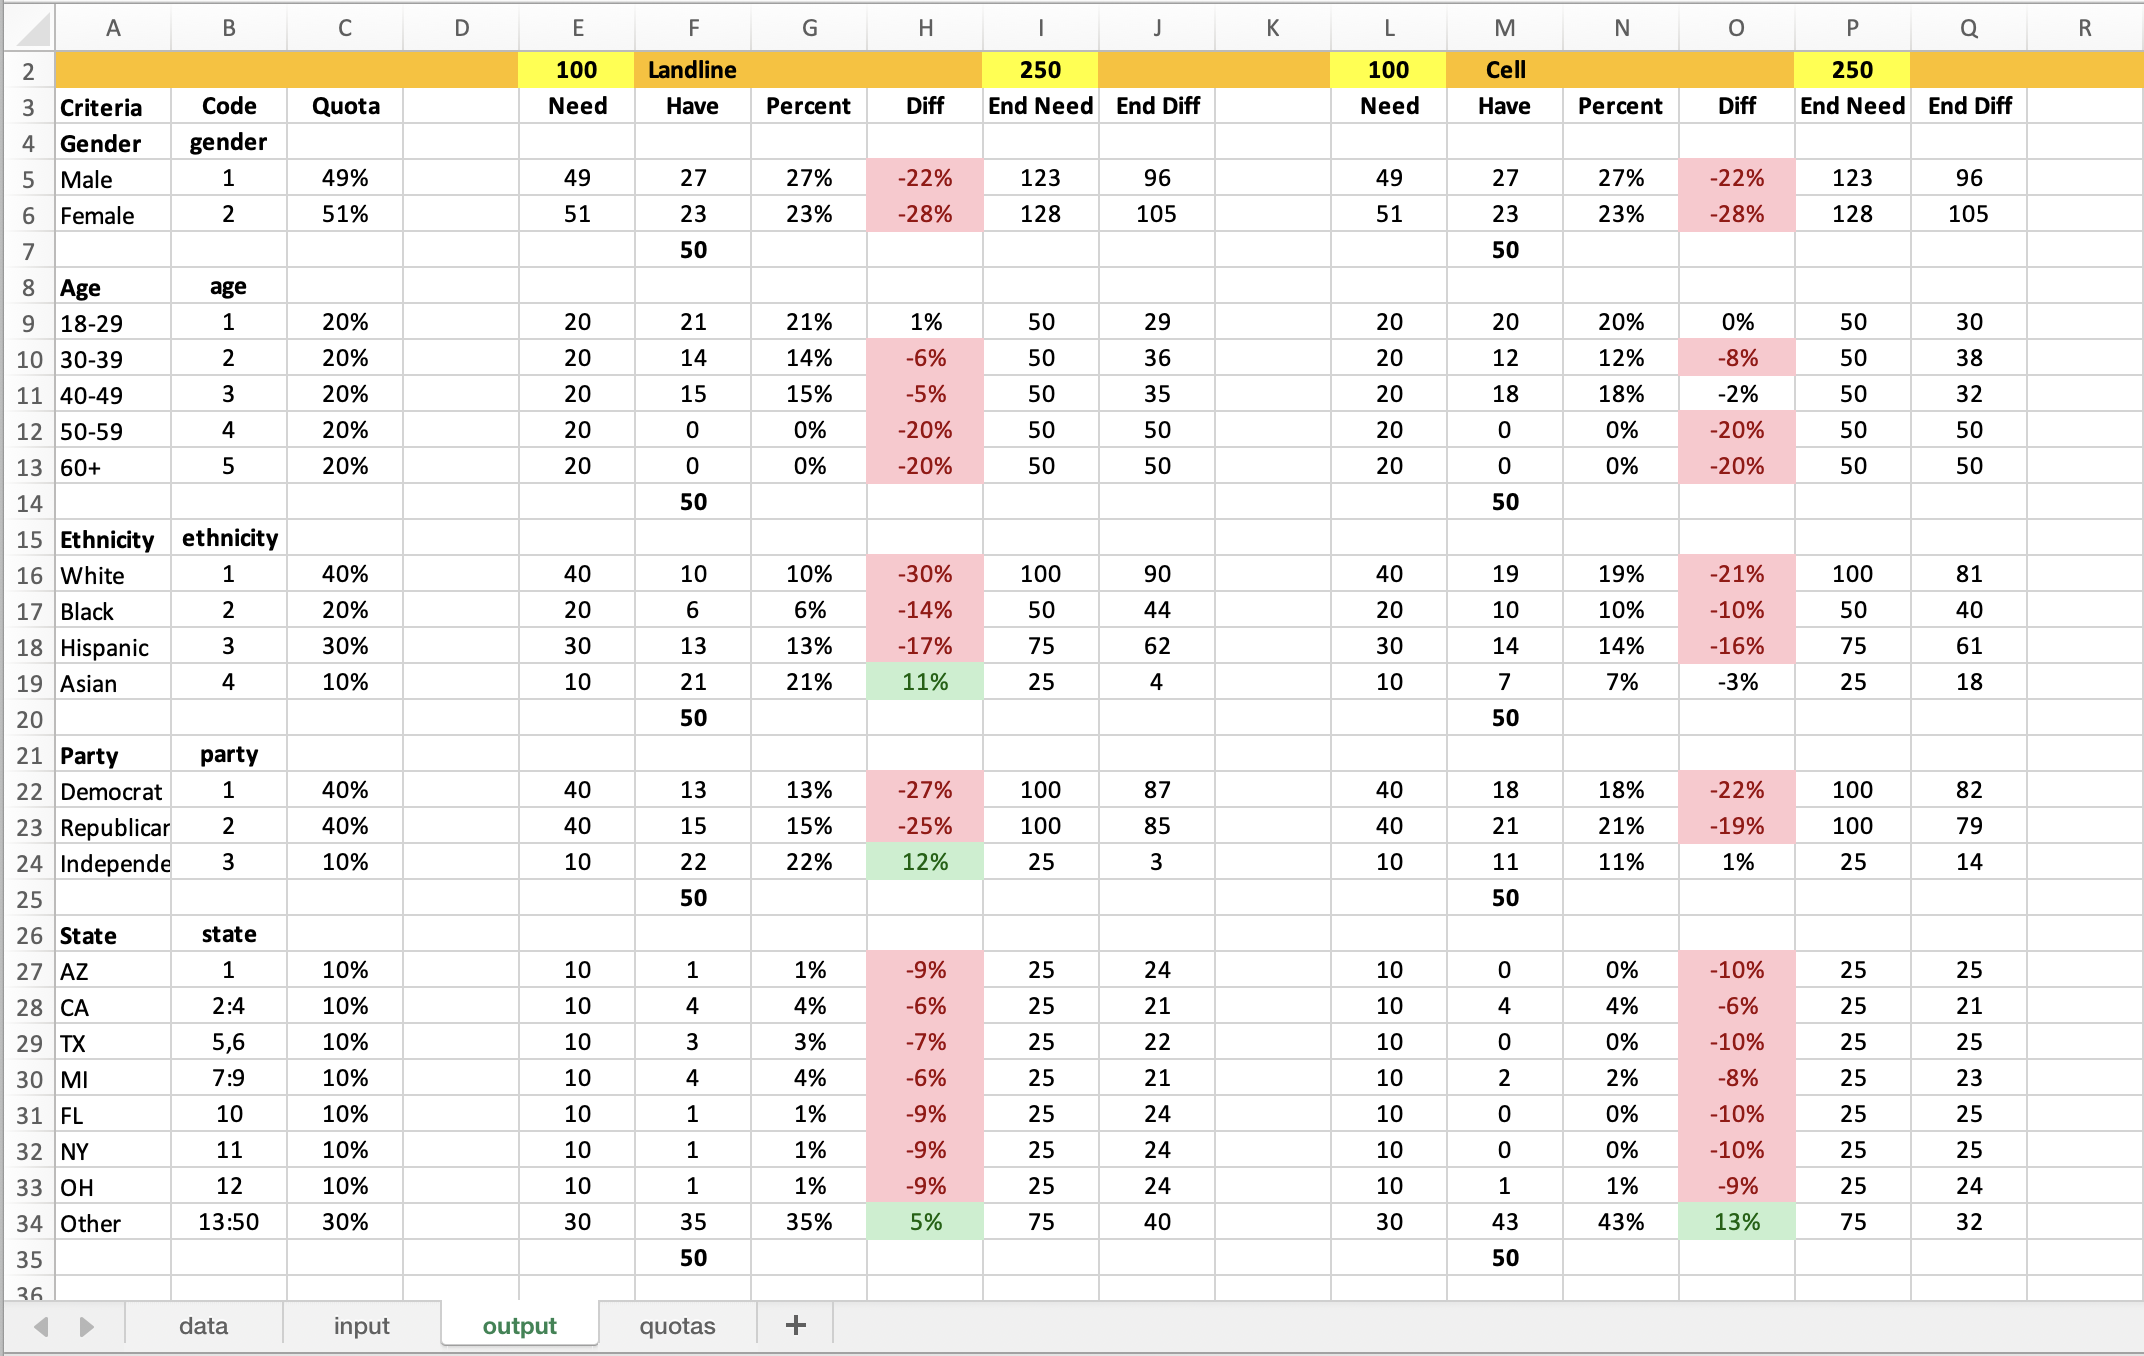

### 3RD USE CASE - MANY SAMPLES - 1 QUOTA (SAMPLES TRACKED FROM DIFFERENT COLUMNS)

In [6]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import re

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.formatting.rule import FormulaRule


# INPUT SESSION

file_path = r'/Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx'
codesheet = pd.read_excel(file_path, sheet_name='input')
data = pd.read_excel(file_path, sheet_name='data')

configurations = [
    {"sample_col": "Sample", "sample_code": 1, "daily_target": 100, "end_target": 250},
    {"sample_col": "gender", "sample_code": 2, "daily_target": 100, "end_target": 250},
    # {"sample_col": "Modetype", "sample_code": 3, "daily_target": 40, "end_target": 100},
    # {"sample_col": "Modetype", "sample_code": '', "daily_target": 120, "end_target": 300}
]

one_quota=True # Turn on when tracking many samples but only 1 quota is used across samples. 
quota_name=['Base', 'Female'] # 'Text', 'Total'] # Default setting for G2, adjust it as you want but it only gets affected if one_quota is True

flex=0.03

diff_above_col_color = '#c6efce' # Color for conditional formatting of Diff column - fill > flex
diff_above_text_color = '#006100' # Color for conditional formatting of Diff column - text > flex

diff_below_col_color = '#ffc7ce' # Color for conditional formatting of Diff column - fill < flex
diff_below_text_color = '#9c0006' # Color for conditional formatting of Diff column - text < flex

end_diff_col_color = '#ffeb9c' # Color for conditional formatting of End Diff column - fill
end_diff_text_color = '#9c5700'  # Color for conditional formatting of End Diff column - text
print()


# VALIDATION - WARNING IF THE SETUP IS INCORRECT

sample_col = [i["sample_col"] for i in configurations]
sample_code = [i["sample_code"] for i in configurations]
daily_target = [i["daily_target"] for i in configurations]
end_target = [i["end_target"] for i in configurations]

stop=False

if len(daily_target) != len(end_target):
    print("The number of daily_target and end_target must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_col) != len(sample_code):
    print("The number of sample_col and sample_code must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_code)>0 and (len(daily_target) != len(sample_code) or len(end_target) != len(sample_code)):
    print("Length of sample_code does not match daily_target and end_target. If tracking MORE THAN 1 sample, their length must always be the same. Please adjust the script!\n")
    stop=True

if one_quota and (len(sample_col)==0 or len(sample_code)==0):
    print('Only set one_quota=True if there are MORE THAN 1 sample to track. Please adjust the script\n')
    stop=True

if one_quota and (len(quota_name) != len(daily_target) or len(quota_name) != len(end_target) or len(quota_name) != len(sample_code)):
    print("If one_quota=True, length of quota_name must fit daily_target's, end_target's and sample_code's. Please adjust the script\n")
    stop=True

if 'Criteria' not in list(codesheet.columns) or 'Code' not in list(codesheet.columns) or 'Column' not in list(codesheet.columns): 
        print("Can not find 'Criteria', 'Code' or 'Column' column in the input codesheet. Please check the codesheet!\n")
        stop=True  

if not any(i.startswith('Flex') for i in list(codesheet.columns)):
    print("Can not find any 'Flex' column in the input codesheet. Please check the codesheet!\n")
    stop=True

if one_quota==False:
    if len(daily_target)>1 and not any(i.startswith('Quota_') for i in list(codesheet.columns)):
        print('In this case, the quota columns have to start with "Quota_". Please check the codesheet!\n')
        stop=True
    elif len(daily_target)==1 and 'Quota' not in list(codesheet.columns):
        print("Can not find the quota column, it must be 'Quota'. Please check the codesheet!\n")
        stop=True

if one_quota and 'Quota' not in list(codesheet.columns):
    print("It does not seem like there is only one quota to be used. Please check the codesheet!\n")
    stop=True  

quota_col_num = len([c for c in codesheet.columns if c.startswith("Quota")])

if quota_col_num > 1:
    quota_col_name= [i.split("_")[1] for i in codesheet.columns if i.startswith('Quota')]
else:
    quota_col_name = ['']

flex_col_num = len([c for c in codesheet.columns if c.startswith("Flex")])

if flex_col_num > 1:
    flex_col_name = [i.split("_")[1] for i in codesheet.columns if i.startswith('Flex')]
else:
    flex_col_name = [''] 

if quota_col_num == 1 and flex_col_num != 1:
    print("There is only one quota column but multiple flex columns. Please check the codesheet!\n")
    stop=True

if quota_col_num != 1 and flex_col_num != 1 and quota_col_num != flex_col_num:
    print("The number of quota columns does not match the number of flex columns. Please check the codesheet!\n")
    stop=True

if flex_col_num == quota_col_num and set(flex_col_name) != set(quota_col_name):
    print("The names of quota columns do not match the names of flex columns. Please check the codesheet!\n")
    stop=True

j=[]
for i in codesheet['Column']:
    if not pd.isna(i) and i not in list(data.columns):
        j.append(i)
        stop=True    

if j != []:
    print(f"Can not find the column '{', '.join(j)}' in the input data. Please check the codesheet!\n")

def validate_code(value):
    if pd.isna(value):
        return True
    
    val = str(value).strip()
    
    if re.fullmatch(r"\d+", val):
        return True
    
    if re.fullmatch(r"\d+\.0+", val):
        return True
    
    if re.fullmatch(r"\d+:\d+", val):
        return True
    
    if re.fullmatch(r"\d+-\d+", val):
        return True
    
    if re.fullmatch(r"(\d+,)+\d+", val):
        return True
    
    return False

invalid_rows = codesheet[~codesheet['Code'].apply(validate_code)]

if not invalid_rows.empty:
    print("The following Code(s) are invalid. Please check the codesheet!\n")
    print(invalid_rows[['Code']])
    stop=True

if stop:
    raise SystemExit("❌ Program stopped due to validation errors. Please check your input in this code\n")    

print('⌛ Co Tam is working on it! Should be done real quick!\n')


# CLEAN UP THE INPUT CODESHEET

col_order1 = [i for i in codesheet.columns if not i.startswith(('Criteria', 'Code', 'Column', 'Quota', 'Flex'))]
col_order2 = ['Criteria', 'Code', 'Column']
col_order3 = [i for i in codesheet.columns if i.startswith(('Quota'))]
flex_order = [i for i in codesheet.columns if i.startswith(('Flex'))]

codesheet = codesheet.reindex(columns=col_order1 + col_order2 + col_order3 + flex_order)

codesheet['Blankrows'] = 1

for i in range(len(codesheet)-2):
    if pd.isna(codesheet.loc[i, 'Code']) and pd.isna(codesheet.loc[i, 'Column']) and pd.isna(codesheet.loc[i+1, 'Code']) and pd.isna(codesheet.loc[i+1, 'Column']) and pd.isna(codesheet.loc[i+2, 'Code']) and pd.isna(codesheet.loc[i+2, 'Column']):
        codesheet.loc[i, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)
codesheet = codesheet.reset_index(drop=True)

if pd.isna(codesheet.loc[0, 'Criteria']) and pd.isna(codesheet.loc[0, 'Code']) and pd.isna(codesheet.loc[0, 'Column']):
    codesheet.loc[0, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)

codesheet.drop(columns=[col for col in codesheet.columns if col.startswith(('Unnamed', 'Blankrows'))], inplace=True)

if len(col_order1)!=0:
    codesheet.insert(codesheet.columns.get_loc("Criteria"), "", np.nan)
codesheet = codesheet.reset_index(drop=True)


# CREATE THE QUOTA LIST FROM THE INPUT AND THE "quotas" SHEETS FOR BAOLANCER

if len(sample_col) == 1:
    sample_col = sample_col * len(sample_code)

if one_quota==True:
    for i in quota_name:
        codesheet.insert(codesheet.columns.get_loc('Quota'), f'Quota_{i}', codesheet['Quota'])
    codesheet.drop(columns='Quota', inplace=True)    
    quota_list = [f'Quota_{i}' for i in quota_name]
else:    
    quota_list = codesheet.columns[codesheet.columns.str.startswith('Quota')].tolist()

df_quotas = {}

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    df = pd.DataFrame()
    df['Column'] = codesheet['Column']
    df['Quota'] = codesheet[quota_name]
    df['Code'] = codesheet['Code']

    if any("_" in item for item in flex_order):
        df['Flex'] = codesheet[f"Flex{quota_name[quota_name.find('_'):]}"] 
    else:
        df['Flex'] = codesheet['Flex']
    df_quotas[key] = df

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    
    df = df_quotas[key].copy()
    df = df.dropna(subset=['Quota'])  
    df_quotas[key] = df

# ADD FLEX TO THE QUOTA CODESHEET IF IT IS MISSING

for i in flex_order:
    if len(flex_order) == 1:
        codesheet['Flex'] = codesheet['Flex'].fillna(flex)
    else:
        key = i[i.find('_'):]
        codesheet[f'Flex{key}'] = codesheet[f'Flex{key}'].fillna(flex)


# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([empty_rows, codesheet], ignore_index=True)


# INSERT daily (target), NEED, HAVE, PERCENT, DIFF, END NEED, END DIFF, final (target), placerholder COLUMNS. ADJUST THEIR DATA TYPES

for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]
    
    col_idx = codesheet.columns.get_loc(i)

    codesheet.insert(col_idx, f'daily{key}', np.nan)
    codesheet.insert(col_idx+2, f'Need{key}', np.nan)
    codesheet.insert(col_idx+3, f'Have{key}', np.nan)
    codesheet.insert(col_idx+4, f'Percent{key}', np.nan)
    codesheet.insert(col_idx+5, f'Diff{key}', np.nan)
    codesheet.insert(col_idx+6, f'End Need{key}', np.nan)
    codesheet.insert(col_idx+7, f'End Diff{key}', np.nan)
    codesheet.insert(col_idx+8, f'final{key}', np.nan)
    codesheet.insert(col_idx+9, f'placeholder{key}', np.nan)

j=0
for i in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    codesheet.loc[0, f'Need{key}'] = daily_target[j] 
    codesheet.loc[0, f'End Need{key}'] = end_target[j] 
    j += 1

    if one_quota==True:
        codesheet['Quota']=codesheet[f'Quota{key}']
        col_list=list(codesheet.columns)
        col_list.remove('Quota')
        col_list.insert(codesheet.columns.get_loc('Code'), 'Quota')
        codesheet=codesheet[col_list]    

for i in codesheet.columns:
    codesheet[i] = codesheet[i].astype('object')


# CREATE THE CLEANED HEADER ROWS FOR THE CODESHEET

for i in codesheet.columns:
    if i in ['Criteria', 'Code', 'Quota', 'Need', 'Have', 'Percent', 'Diff', 'End Need', 'End Diff'] or i in col_order1:
        codesheet.loc[1, i] = i
    elif i.startswith(('Quota_', 'Need_', 'Have_', 'Percent_', 'Diff_', 'End Need_', 'End Diff_')):
        codesheet.loc[1, i] = i.split('_')[0]

    if i.startswith('Have'):
        codesheet.loc[0, i] = i.split('_')[1] if '_' in i else ''    

# CREATE FUNCTIONS

# Convert column index in Python to column name in Excel
def index_to_excel_column(n):
    result = ''
    while n >= 0:
        result = chr(n % 26 + ord('A')) + result
        n = n // 26 - 1
    return result.upper()

# Generate list of codes from the "Code" column
def define_code(code):
    if str(code).__contains__(":"):
        range_part = str(code).replace("'", "").split(':')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    elif str(code).__contains__("-"):
        range_part = str(code).replace("'", "").split('-')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    else:    
        list_code = str(code).split(',')

    return list_code

# DROP DAILY TARGET AND FINAL TARGET COLUMNS
# These columns are not needed but because they affect the structure of the codesheet, they are created first and then dropped at the end.
codesheet = codesheet.drop(
    columns=[c for c in codesheet.columns if c.startswith("daily") or c.startswith("final")]
)

# GET THE COLUMN NAMES OF REFERRED COLUMNS TO USE IN THE FORMULAS

col_locs = {}
for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    if one_quota==True:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc('Quota'))
        codesheet.drop(columns=i, inplace=True)
    else:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(i))    
    
    col_locs[f'Need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Need{key}'))
    col_locs[f'have{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Have{key}'))
    col_locs[f'percent{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Percent{key}'))
    col_locs[f'diff{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Diff{key}'))
    col_locs[f'end_need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'End Need{key}'))

    
code_loc=index_to_excel_column(codesheet.columns.get_loc('Code'))

sample_loc=[]
if len(sample_col)>0:
    for i in range(len(sample_col)):
        sample_loc.append(index_to_excel_column(data.columns.get_loc(sample_col[i])))

# CREATE THE FORMULAS

# One sample
if len(quota_list)==1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):

            key = ''

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')

                list_code = define_code(codesheet.loc[i, 'Code'])

                col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = (f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})')
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (f'COUNTIFS(data!${col_excel}:${col_excel},{list_code[x]})')
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})'
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (
                            f"COUNTIFS(data!${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))}:"
                            f"${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))},{list_code[x]})"
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
            
            if (not pd.isna(codesheet.loc[i, f'Quota{key}'])) and (codesheet.loc[i, f'Quota{key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f'={percent_col}{i+2}-{quota_col}{i+2}'
                codesheet.loc[i, f'End Need{key}'] = f'={quota_col}{i+2}*{end_need_col}$2'
                codesheet.loc[i, f'End Diff{key}'] = f'={end_need_col}{i+2}-{have_col}{i+2}'

        a += 1

# More than one samples
if len(quota_list)>1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):
            
            key = j[j.find('_'):]

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')
                
                list_code = define_code(codesheet.loc[i, 'Code'])

                if sample_code[a-1] == '':
                    if len(list_code) == 1:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        codesheet.loc[i, f'Have{key}'] = f"=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})"
                    else:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        Have_formula_part = '=' + '+'.join(
                            [f"COUNTIFS(data!${col_excel}:${col_excel},{code})" for code in list_code]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
                else:
                    col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                    if len(list_code) == 1:
                        codesheet.loc[i, f'Have{key}'] = (
                            f"=COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                            f"data!${col_excel}:${col_excel},${code_loc}{i+2})"
                        )
                    else:
                        Have_formula_part = '=' + '+'.join(
                            [
                                f"COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                                f"data!${col_excel}:${col_excel},{code})"
                                for code in list_code
                            ]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

            if one_quota==True:
                quota_col_key = ''
            else:
                quota_col_key = key

            if (not pd.isna(codesheet.loc[i, f'Quota{quota_col_key}'])) and (codesheet.loc[i, f'Quota{quota_col_key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f"={percent_col}{i+2}-{quota_col}{i+2}"
                codesheet.loc[i, f'End Need{key}'] = f"={quota_col}{i+2}*{end_need_col}$2"
                codesheet.loc[i, f'End Diff{key}'] = f"={end_need_col}{i+2}-{have_col}{i+2}"
    
        a += 1    

# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([codesheet, empty_rows], ignore_index=True)


# CREATE FORMULA TO CALCULATE SUM

a=0
b=0
for j in quota_list:
    for i in range(1, len(codesheet)-1):
       
        if len(quota_list) == 1:
            ''
        else:
            key = j[j.find('_'):]

        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i-1, f'Have{key}']):
            a=i+2
        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i+1, f'Have{key}']):
            b=i+2

        if pd.isna(codesheet.loc[i, f'Have{key}']) and pd.isna(codesheet.loc[i+1, f'Have{key}']):
            have_col = col_locs[f"have{key}_loc"]
            codesheet.loc[i, f"Have{key}"] = f"=SUM({have_col}{a}:{have_col}{b})"

    for i in range(len(codesheet)-1):
        if pd.isna(codesheet['Code'][i]) & (not pd.isna(codesheet['Code'][i+1])):
            codesheet.loc[i, 'Code'] = codesheet.loc[i + 1, 'Column']
        codesheet.loc[i, 'Column']=np.nan    


# CREATE TWO LISTS OF ROWS TO STORE THE POSITION OF ROWS THAT NEED BOLD FORMATTING & CONDITIONAL FORMATTING

bold_dict = {}  
conditional_formatting_dict = {}

for j in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = j[j.find('_'):]
    
    bold_dict[j] = [0, 1]
    conditional_formatting_dict[j] = []

    for i in range(len(codesheet)):
  
        if ((not pd.isna(codesheet.loc[i, 'Criteria'])) & (not pd.isna(codesheet.loc[i, 'Code'])) & (pd.isna(codesheet.loc[i, f'Have{key}']))) or ((pd.isna(codesheet.loc[i, 'Criteria'])) & (pd.isna(codesheet.loc[i, 'Code'])) & (not pd.isna(codesheet.loc[i, f'Have{key}']))):
            bold_dict[j].append(i)

        if (not pd.isna(codesheet.loc[i, f'Diff{key}'])):
            conditional_formatting_dict[j].append(i)


# DROP UNNECESSARY COLUMNS

new_columns = []

for col in codesheet.columns:
    if col == 'Column' or col.startswith(('placeholder', 'daily', 'final')):
        new_columns.append("")
    elif one_quota & col.startswith('Quota_'):
        codesheet[col]=np.nan
        new_columns.append("")
    else:
        new_columns.append(col)

codesheet.columns = new_columns


# WRITE THE PROCESSED CODESHEET AND THE 'quotas' TABS IN THE ORIGINAL FILE

flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]
codesheet_to_save = codesheet.drop(columns=flex_cols)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    codesheet_to_save.to_excel(writer, sheet_name='output', index=False, header=False, startrow=1)

    for quota_name in quota_list:
        if len(quota_list) == 1:
            key = ''
        else:
            key = quota_name[quota_name.find('_'):]
        if one_quota==True:
            df_quotas[key].to_excel(writer, sheet_name='quotas', index=False, header=True, startrow=0)
        else:    
            df_quotas[key].to_excel(writer, sheet_name=f'quotas{key.replace("_","")}', index=False, header=True, startrow=0)


# FORMAT THE CODESHEET

wb = load_workbook(file_path)
ws = wb['output']

# Style
bold_center = Alignment(horizontal='center', vertical='center')
bold_font = Font(bold=True)
center_alignment = Alignment(horizontal='center', vertical='center')
left_alignment = Alignment(horizontal='left', vertical='center')


# Header formatting
header_names = list(codesheet_to_save.columns)
for col_idx, col_name in enumerate(header_names, 1):
    cell = ws.cell(row=1, column=col_idx, value=col_name)
    # cell.font = bold_font
    cell.alignment = bold_center

# Percentage formatting
percent_cols = [i for i in list(codesheet.columns) if i.startswith('Quota') or  i.startswith('Percent') or i.startswith('Diff')]

col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}
criteria_col_index = col_indices.get('Criteria', None)

for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        if header_names[cell.column - 1] in percent_cols:
            cell.number_format = '0%'

        if cell.column != criteria_col_index:
            cell.alignment = center_alignment   

# Bold formatting
for quota_name_x, rows_list in bold_dict.items():
    for df_row in rows_list:
        excel_row = df_row + 2 
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=excel_row, column=col)
            cell.font = bold_font
            if cell.column != criteria_col_index:
                cell.alignment = center_alignment


# Round formatting
round_cols = [i for i in list(codesheet.columns) if i.startswith('Need') or  i.startswith('End Need') or i.startswith('End Diff')]
col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}

for col_name in round_cols:
    col_index = col_indices.get(col_name)

    for row in range(2, ws.max_row + 1): 
        cell = ws.cell(row=row, column=col_index)
        cell.number_format = '0' 


# Conditional formatting
fill_above_diff = PatternFill(start_color=diff_above_col_color.replace('#',''), end_color=diff_above_col_color.replace('#',''), fill_type='solid')
font_above_diff = Font(color=diff_above_text_color.replace('#', ''))

fill_below_diff = PatternFill(start_color=diff_below_col_color.replace('#',''), end_color=diff_below_col_color.replace('#',''), fill_type='solid')
font_below_diff = Font(color=diff_below_text_color.replace('#', ''))

fill_end_diff = PatternFill(start_color=end_diff_col_color.replace('#',''), end_color=end_diff_col_color.replace('#',''), fill_type='solid')
font_end_diff = Font(color=end_diff_text_color.replace('#', ''))


flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]

for col in codesheet.columns:
    if col.startswith("Diff") and not col.startswith("End Diff"):
        diff_col_index = col_indices.get(col)
        if diff_col_index:
            col_letter = ws.cell(row=2, column=diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                if len(flex_cols) == 1:
                    flex_value = codesheet.loc[row-2, flex_cols[0]]
                else:
                    suffix = col[len("Diff"):]
                    flex_col = f"Flex{suffix}"
                    flex_value = codesheet.loc[row-2, flex_col]

                if pd.isna(flex_value):
                    continue

                cell = f"{col_letter}{row}"

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < {-float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_below_diff,
                        font=font_below_diff
                    )
                )

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} > {float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_above_diff,
                        font=font_above_diff
                    )
                )

    elif col.startswith("End Diff"):
        end_diff_col_index = col_indices.get(col)
        if end_diff_col_index:
            col_letter = ws.cell(row=2, column=end_diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                cell = f"{col_letter}{row}"
                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < 0)'],
                        stopIfTrue=True,
                        fill=fill_end_diff,
                        font=font_end_diff
                    )
                )

# Color the second row
orange_fill = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=2, column=col)
    cell.fill = orange_fill


# Highlight daily target and final target
highlight_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid") 

for col_name, col_index in col_indices.items():
    if col_name.startswith("Need") or col_name.startswith("End Need"):
        cell = ws.cell(row=2, column=col_index)
        cell.fill = highlight_fill

wb.save(file_path)

print(f"✅ Co Tam has finished! 'output' has been added to the data file {file_path}")



⌛ Co Tam is working on it! Should be done real quick!

✅ Co Tam has finished! 'output' has been added to the data file /Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - One quota column.xlsx


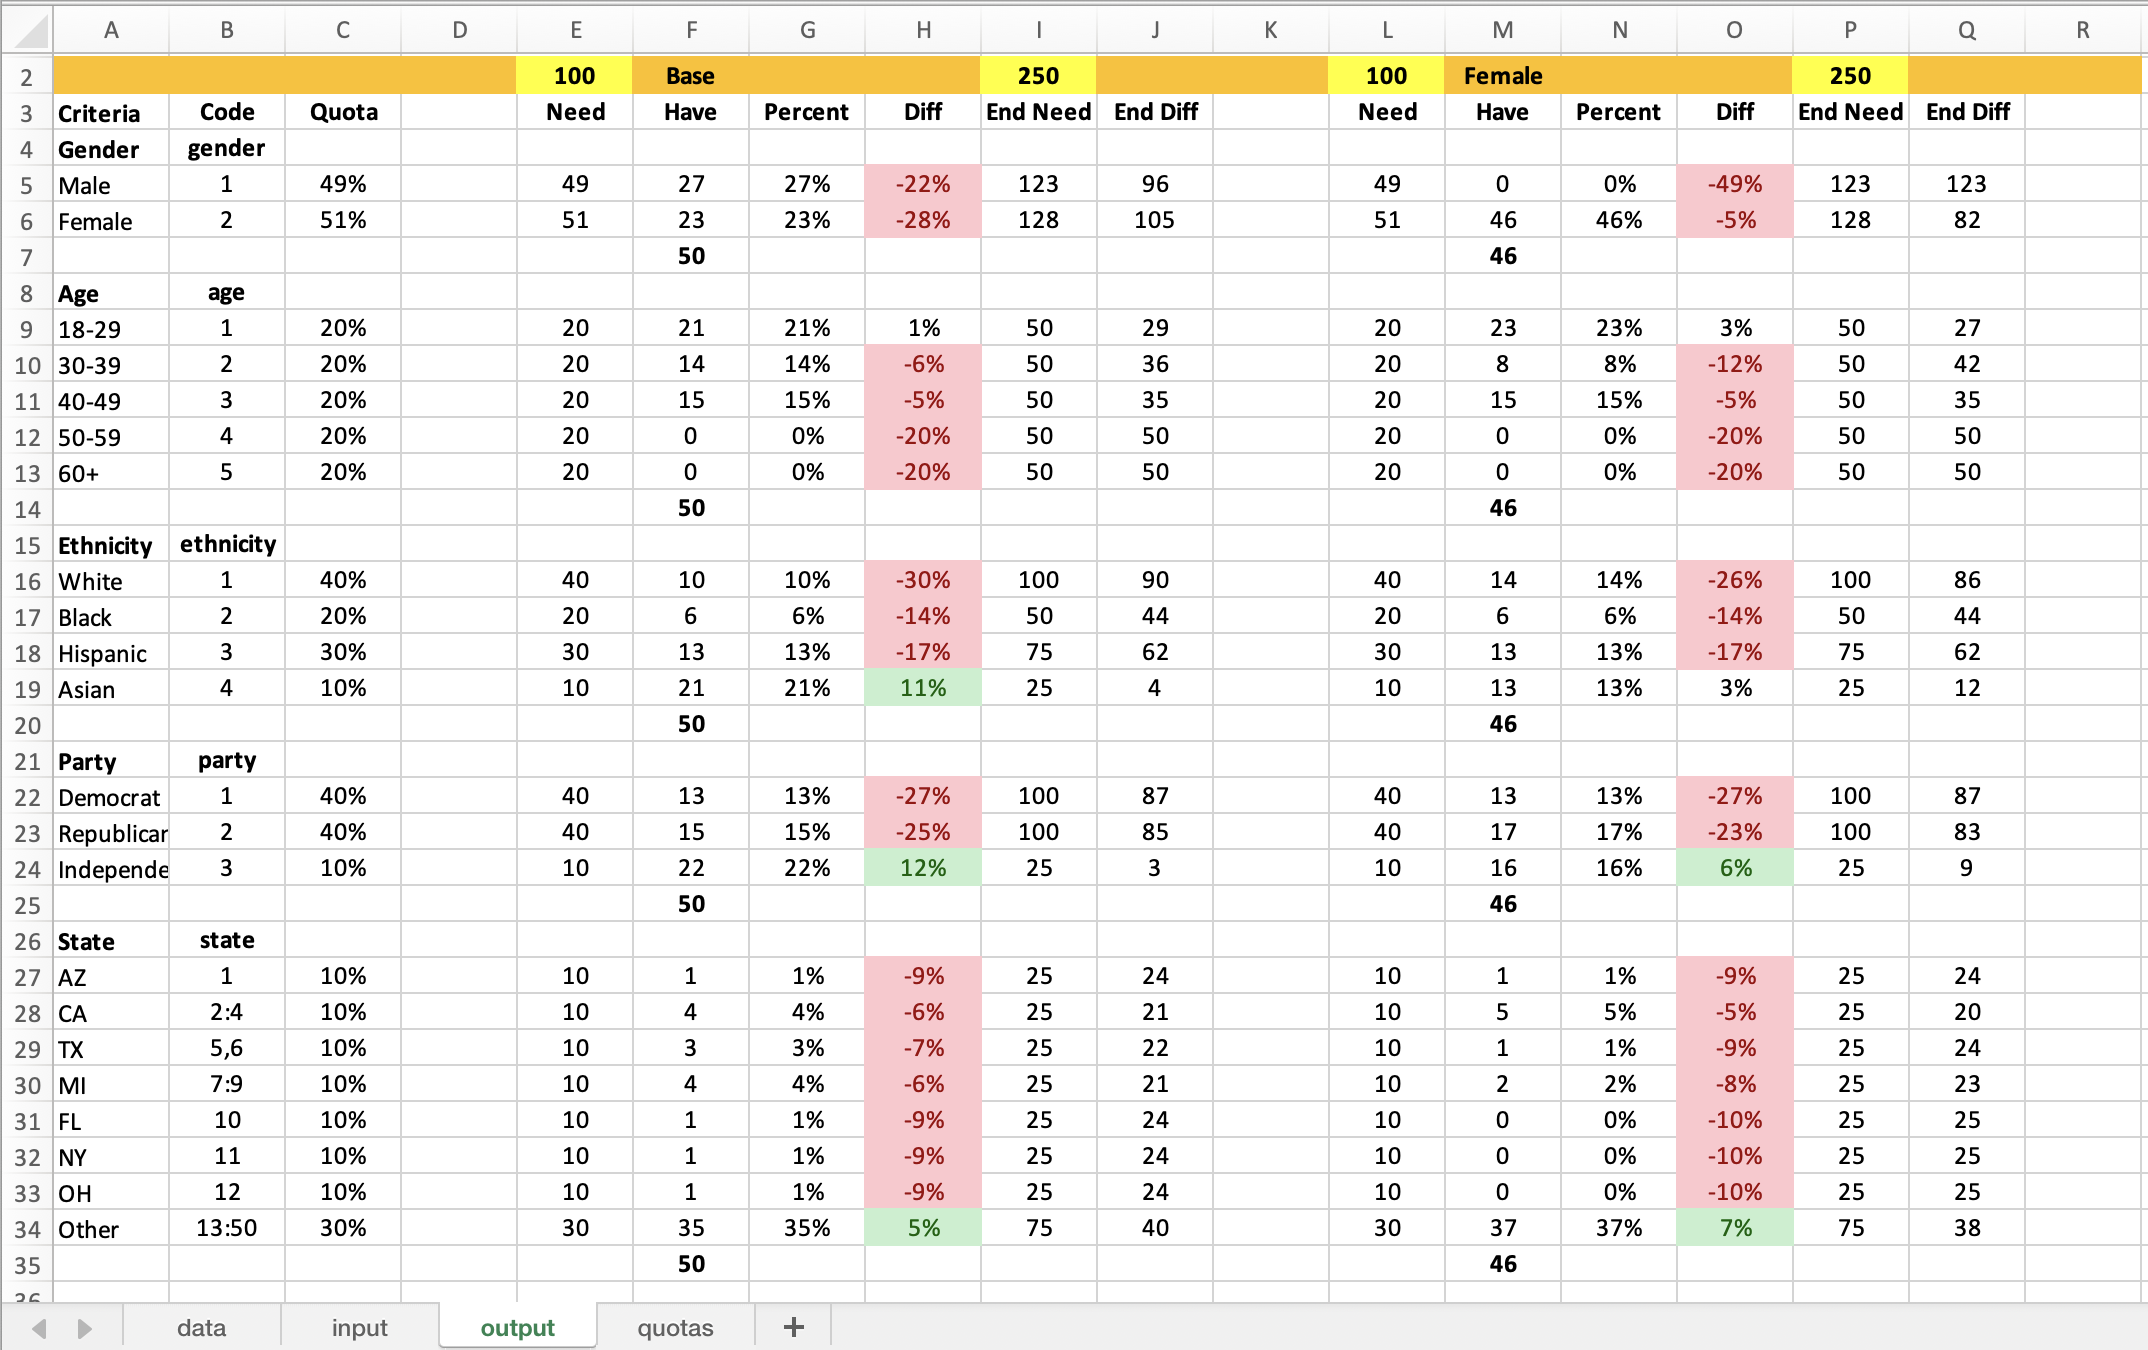

## SECTION 2. MANY QUOTA CASES

### 4TH USE CASE - MANY SAMPLES - MANY QUOTA

The input will look like this

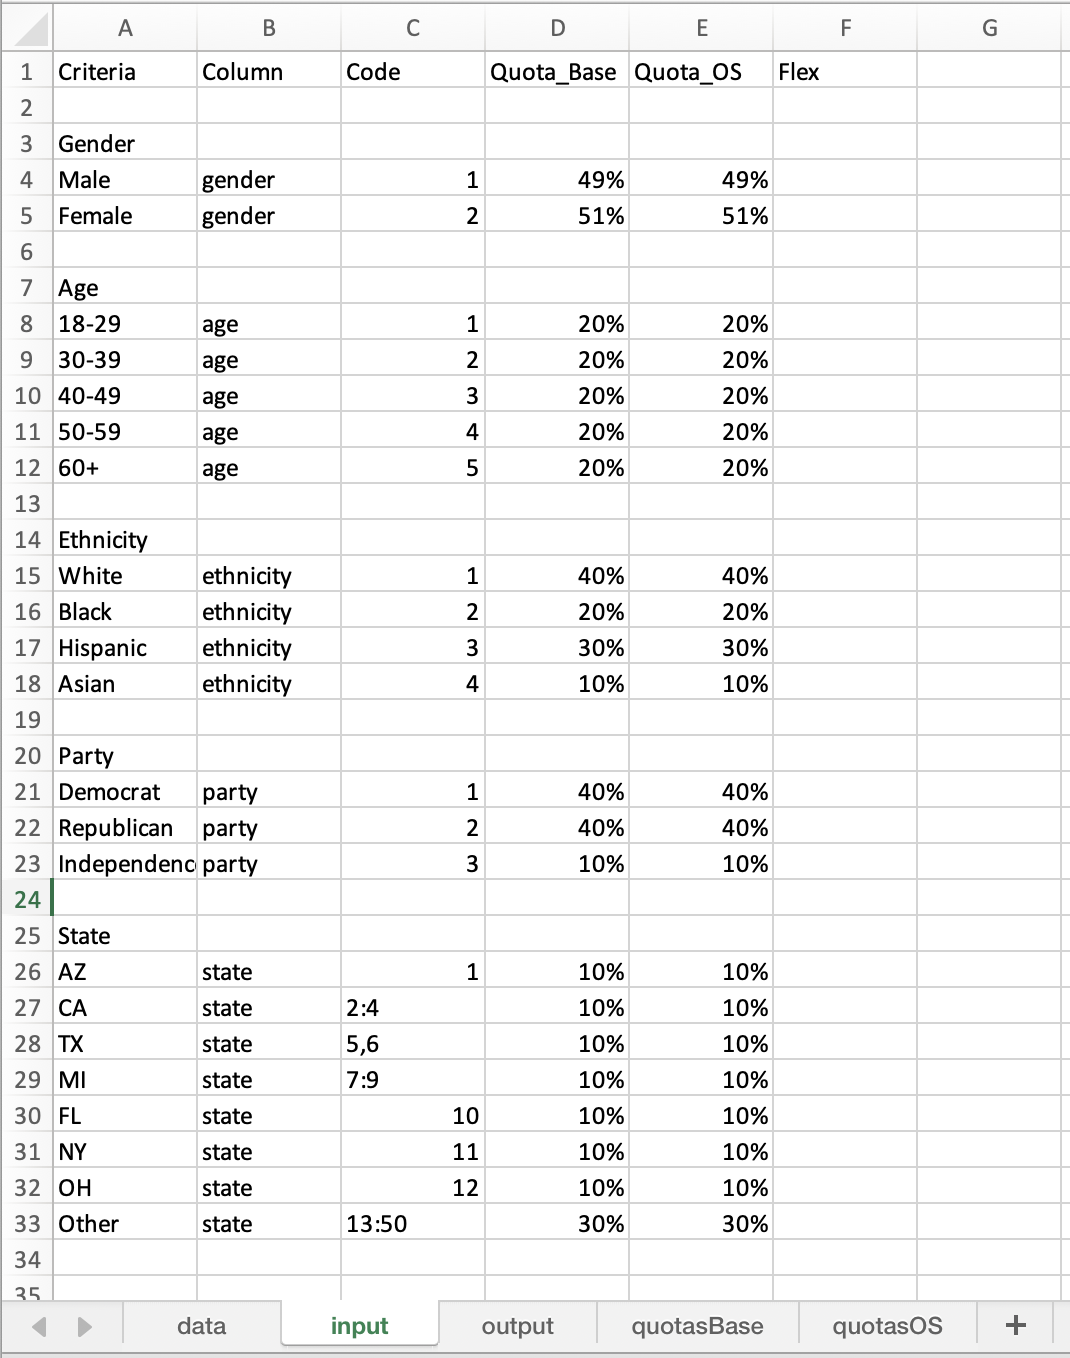

In [11]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import re

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.formatting.rule import FormulaRule


# INPUT SESSION

file_path = r'/Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - Many quota column.xlsx'
codesheet = pd.read_excel(file_path, sheet_name='input')
data = pd.read_excel(file_path, sheet_name='data')

configurations = [
    {"sample_col": "Sample", "sample_code": 1, "daily_target": 100, "end_target": 250},
    {"sample_col": "Sample", "sample_code": 2, "daily_target": 100, "end_target": 250},
    # {"sample_col": "Modetype", "sample_code": 3, "daily_target": 40, "end_target": 100},
    # {"sample_col": "Modetype", "sample_code": '', "daily_target": 120, "end_target": 300}
]

one_quota=False # Turn on when tracking many samples but only 1 quota is used across samples. 
quota_name=['Base', 'Female'] # 'Text', 'Total'] # Default setting for G2, adjust it as you want but it only gets affected if one_quota is True

flex=0.03

diff_above_col_color = '#c6efce' # Color for conditional formatting of Diff column - fill > flex
diff_above_text_color = '#006100' # Color for conditional formatting of Diff column - text > flex

diff_below_col_color = '#ffc7ce' # Color for conditional formatting of Diff column - fill < flex
diff_below_text_color = '#9c0006' # Color for conditional formatting of Diff column - text < flex

end_diff_col_color = '#ffeb9c' # Color for conditional formatting of End Diff column - fill
end_diff_text_color = '#9c5700'  # Color for conditional formatting of End Diff column - text
print()


# VALIDATION - WARNING IF THE SETUP IS INCORRECT

sample_col = [i["sample_col"] for i in configurations]
sample_code = [i["sample_code"] for i in configurations]
daily_target = [i["daily_target"] for i in configurations]
end_target = [i["end_target"] for i in configurations]

stop=False

if len(daily_target) != len(end_target):
    print("The number of daily_target and end_target must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_col) != len(sample_code):
    print("The number of sample_col and sample_code must always be the same. Please adjust the script!\n")
    stop=True

if len(sample_code)>0 and (len(daily_target) != len(sample_code) or len(end_target) != len(sample_code)):
    print("Length of sample_code does not match daily_target and end_target. If tracking MORE THAN 1 sample, their length must always be the same. Please adjust the script!\n")
    stop=True

if one_quota and (len(sample_col)==0 or len(sample_code)==0):
    print('Only set one_quota=True if there are MORE THAN 1 sample to track. Please adjust the script\n')
    stop=True

if one_quota and (len(quota_name) != len(daily_target) or len(quota_name) != len(end_target) or len(quota_name) != len(sample_code)):
    print("If one_quota=True, length of quota_name must fit daily_target's, end_target's and sample_code's. Please adjust the script\n")
    stop=True

if 'Criteria' not in list(codesheet.columns) or 'Code' not in list(codesheet.columns) or 'Column' not in list(codesheet.columns): 
        print("Can not find 'Criteria', 'Code' or 'Column' column in the input codesheet. Please check the codesheet!\n")
        stop=True  

if not any(i.startswith('Flex') for i in list(codesheet.columns)):
    print("Can not find any 'Flex' column in the input codesheet. Please check the codesheet!\n")
    stop=True

if one_quota==False:
    if len(daily_target)>1 and not any(i.startswith('Quota_') for i in list(codesheet.columns)):
        print('In this case, the quota columns have to start with "Quota_". Please check the codesheet!\n')
        stop=True
    elif len(daily_target)==1 and 'Quota' not in list(codesheet.columns):
        print("Can not find the quota column, it must be 'Quota'. Please check the codesheet!\n")
        stop=True

if one_quota and 'Quota' not in list(codesheet.columns):
    print("It does not seem like there is only one quota to be used. Please check the codesheet!\n")
    stop=True  

quota_col_num = len([c for c in codesheet.columns if c.startswith("Quota")])

if quota_col_num > 1:
    quota_col_name= [i.split("_")[1] for i in codesheet.columns if i.startswith('Quota')]
else:
    quota_col_name = ['']

flex_col_num = len([c for c in codesheet.columns if c.startswith("Flex")])

if flex_col_num > 1:
    flex_col_name = [i.split("_")[1] for i in codesheet.columns if i.startswith('Flex')]
else:
    flex_col_name = [''] 

if quota_col_num == 1 and flex_col_num != 1:
    print("There is only one quota column but multiple flex columns. Please check the codesheet!\n")
    stop=True

if quota_col_num != 1 and flex_col_num != 1 and quota_col_num != flex_col_num:
    print("The number of quota columns does not match the number of flex columns. Please check the codesheet!\n")
    stop=True

if flex_col_num == quota_col_num and set(flex_col_name) != set(quota_col_name):
    print("The names of quota columns do not match the names of flex columns. Please check the codesheet!\n")
    stop=True

j=[]
for i in codesheet['Column']:
    if not pd.isna(i) and i not in list(data.columns):
        j.append(i)
        stop=True    

if j != []:
    print(f"Can not find the column '{', '.join(j)}' in the input data. Please check the codesheet!\n")

def validate_code(value):
    if pd.isna(value):
        return True
    
    val = str(value).strip()
    
    if re.fullmatch(r"\d+", val):
        return True
    
    if re.fullmatch(r"\d+\.0+", val):
        return True
    
    if re.fullmatch(r"\d+:\d+", val):
        return True
    
    if re.fullmatch(r"\d+-\d+", val):
        return True
    
    if re.fullmatch(r"(\d+,)+\d+", val):
        return True
    
    return False

invalid_rows = codesheet[~codesheet['Code'].apply(validate_code)]

if not invalid_rows.empty:
    print("The following Code(s) are invalid. Please check the codesheet!\n")
    print(invalid_rows[['Code']])
    stop=True

if stop:
    raise SystemExit("❌ Program stopped due to validation errors. Please check your input in this code\n")    

print('⌛ Co Tam is working on it! Should be done real quick!\n')


# CLEAN UP THE INPUT CODESHEET

col_order1 = [i for i in codesheet.columns if not i.startswith(('Criteria', 'Code', 'Column', 'Quota', 'Flex'))]
col_order2 = ['Criteria', 'Code', 'Column']
col_order3 = [i for i in codesheet.columns if i.startswith(('Quota'))]
flex_order = [i for i in codesheet.columns if i.startswith(('Flex'))]

codesheet = codesheet.reindex(columns=col_order1 + col_order2 + col_order3 + flex_order)

codesheet['Blankrows'] = 1

for i in range(len(codesheet)-2):
    if pd.isna(codesheet.loc[i, 'Code']) and pd.isna(codesheet.loc[i, 'Column']) and pd.isna(codesheet.loc[i+1, 'Code']) and pd.isna(codesheet.loc[i+1, 'Column']) and pd.isna(codesheet.loc[i+2, 'Code']) and pd.isna(codesheet.loc[i+2, 'Column']):
        codesheet.loc[i, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)
codesheet = codesheet.reset_index(drop=True)

if pd.isna(codesheet.loc[0, 'Criteria']) and pd.isna(codesheet.loc[0, 'Code']) and pd.isna(codesheet.loc[0, 'Column']):
    codesheet.loc[0, 'Blankrows'] = np.nan
codesheet.dropna(subset=['Blankrows'], inplace=True)

codesheet.drop(columns=[col for col in codesheet.columns if col.startswith(('Unnamed', 'Blankrows'))], inplace=True)

if len(col_order1)!=0:
    codesheet.insert(codesheet.columns.get_loc("Criteria"), "", np.nan)
codesheet = codesheet.reset_index(drop=True)


# CREATE THE QUOTA LIST FROM THE INPUT AND THE "quotas" SHEETS FOR BAOLANCER

if len(sample_col) == 1:
    sample_col = sample_col * len(sample_code)

if one_quota==True:
    for i in quota_name:
        codesheet.insert(codesheet.columns.get_loc('Quota'), f'Quota_{i}', codesheet['Quota'])
    codesheet.drop(columns='Quota', inplace=True)    
    quota_list = [f'Quota_{i}' for i in quota_name]
else:    
    quota_list = codesheet.columns[codesheet.columns.str.startswith('Quota')].tolist()

df_quotas = {}

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    df = pd.DataFrame()
    df['Column'] = codesheet['Column']
    df['Quota'] = codesheet[quota_name]
    df['Code'] = codesheet['Code']

    if any("_" in item for item in flex_order):
        df['Flex'] = codesheet[f"Flex{quota_name[quota_name.find('_'):]}"] 
    else:
        df['Flex'] = codesheet['Flex']
    df_quotas[key] = df

for quota_name in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = quota_name[quota_name.find('_'):]
    
    df = df_quotas[key].copy()
    df = df.dropna(subset=['Quota'])  
    df_quotas[key] = df

# ADD FLEX TO THE QUOTA CODESHEET IF IT IS MISSING

for i in flex_order:
    if len(flex_order) == 1:
        codesheet['Flex'] = codesheet['Flex'].fillna(flex)
    else:
        key = i[i.find('_'):]
        codesheet[f'Flex{key}'] = codesheet[f'Flex{key}'].fillna(flex)


# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([empty_rows, codesheet], ignore_index=True)


# INSERT daily (target), NEED, HAVE, PERCENT, DIFF, END NEED, END DIFF, final (target), placerholder COLUMNS. ADJUST THEIR DATA TYPES

for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]
    
    col_idx = codesheet.columns.get_loc(i)

    codesheet.insert(col_idx, f'daily{key}', np.nan)
    codesheet.insert(col_idx+2, f'Need{key}', np.nan)
    codesheet.insert(col_idx+3, f'Have{key}', np.nan)
    codesheet.insert(col_idx+4, f'Percent{key}', np.nan)
    codesheet.insert(col_idx+5, f'Diff{key}', np.nan)
    codesheet.insert(col_idx+6, f'End Need{key}', np.nan)
    codesheet.insert(col_idx+7, f'End Diff{key}', np.nan)
    codesheet.insert(col_idx+8, f'final{key}', np.nan)
    codesheet.insert(col_idx+9, f'placeholder{key}', np.nan)

j=0
for i in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    codesheet.loc[0, f'Need{key}'] = daily_target[j] 
    codesheet.loc[0, f'End Need{key}'] = end_target[j] 
    j += 1

    if one_quota==True:
        codesheet['Quota']=codesheet[f'Quota{key}']
        col_list=list(codesheet.columns)
        col_list.remove('Quota')
        col_list.insert(codesheet.columns.get_loc('Code'), 'Quota')
        codesheet=codesheet[col_list]    

for i in codesheet.columns:
    codesheet[i] = codesheet[i].astype('object')


# CREATE THE CLEANED HEADER ROWS FOR THE CODESHEET

for i in codesheet.columns:
    if i in ['Criteria', 'Code', 'Quota', 'Need', 'Have', 'Percent', 'Diff', 'End Need', 'End Diff'] or i in col_order1:
        codesheet.loc[1, i] = i
    elif i.startswith(('Quota_', 'Need_', 'Have_', 'Percent_', 'Diff_', 'End Need_', 'End Diff_')):
        codesheet.loc[1, i] = i.split('_')[0]

    if i.startswith('Have'):
        codesheet.loc[0, i] = i.split('_')[1] if '_' in i else ''    

# CREATE FUNCTIONS

# Convert column index in Python to column name in Excel
def index_to_excel_column(n):
    result = ''
    while n >= 0:
        result = chr(n % 26 + ord('A')) + result
        n = n // 26 - 1
    return result.upper()

# Generate list of codes from the "Code" column
def define_code(code):
    if str(code).__contains__(":"):
        range_part = str(code).replace("'", "").split(':')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    elif str(code).__contains__("-"):
        range_part = str(code).replace("'", "").split('-')
        list_code = [k for k in range(int(range_part[0]), int(range_part[1])+1)]
    else:    
        list_code = str(code).split(',')

    return list_code

# DROP DAILY TARGET AND FINAL TARGET COLUMNS
# These columns are not needed but because they affect the structure of the codesheet, they are created first and then dropped at the end.
codesheet = codesheet.drop(
    columns=[c for c in codesheet.columns if c.startswith("daily") or c.startswith("final")]
)

# GET THE COLUMN NAMES OF REFERRED COLUMNS TO USE IN THE FORMULAS

col_locs = {}
for i in quota_list:
    if len(quota_list) == 1:
        key = ''
    else:
        key = i[i.find('_'):]

    if one_quota==True:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc('Quota'))
        codesheet.drop(columns=i, inplace=True)
    else:
        col_locs[f'quota{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(i))    
    
    col_locs[f'Need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Need{key}'))
    col_locs[f'have{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Have{key}'))
    col_locs[f'percent{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Percent{key}'))
    col_locs[f'diff{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'Diff{key}'))
    col_locs[f'end_need{key}_loc'] = index_to_excel_column(codesheet.columns.get_loc(f'End Need{key}'))

    
code_loc=index_to_excel_column(codesheet.columns.get_loc('Code'))

sample_loc=[]
if len(sample_col)>0:
    for i in range(len(sample_col)):
        sample_loc.append(index_to_excel_column(data.columns.get_loc(sample_col[i])))

# CREATE THE FORMULAS

# One sample
if len(quota_list)==1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):

            key = ''

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')

                list_code = define_code(codesheet.loc[i, 'Code'])

                col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = (f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})')
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (f'COUNTIFS(data!${col_excel}:${col_excel},{list_code[x]})')
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

                if len(list_code) == 1:
                    codesheet.loc[i, f'Have{key}'] = f'=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})'
                else:
                    Have_formula_part = '='
                    for x in range(len(list_code)):
                        if x > 0:
                            Have_formula_part += '+'
                        Have_formula_part += (
                            f"COUNTIFS(data!${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))}:"
                            f"${index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))},{list_code[x]})"
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
            
            if (not pd.isna(codesheet.loc[i, f'Quota{key}'])) and (codesheet.loc[i, f'Quota{key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f'={percent_col}{i+2}-{quota_col}{i+2}'
                codesheet.loc[i, f'End Need{key}'] = f'={quota_col}{i+2}*{end_need_col}$2'
                codesheet.loc[i, f'End Diff{key}'] = f'={end_need_col}{i+2}-{have_col}{i+2}'

        a += 1

# More than one samples
if len(quota_list)>1:
    a = 1
    for j in quota_list:
        for i in range(len(codesheet)):
            
            key = j[j.find('_'):]

            if not pd.isna(codesheet.loc[i, 'Column']):
                quota_col = col_locs[f'quota{key}_loc']
                need_col = col_locs[f'Need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Need{key}'] = (f'=IF(${quota_col}{i+2}*{need_col}$2=0,"",${quota_col}{i+2}*{need_col}$2)')
                codesheet.loc[i, f'Percent{key}'] = (f'={have_col}{i+2}/{need_col}$2')
                
                list_code = define_code(codesheet.loc[i, 'Code'])

                if sample_code[a-1] == '':
                    if len(list_code) == 1:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        codesheet.loc[i, f'Have{key}'] = f"=COUNTIFS(data!${col_excel}:${col_excel},${code_loc}{i+2})"
                    else:
                        col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                        Have_formula_part = '=' + '+'.join(
                            [f"COUNTIFS(data!${col_excel}:${col_excel},{code})" for code in list_code]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part
                else:
                    col_excel = index_to_excel_column(data.columns.get_loc(codesheet.loc[i, 'Column']))
                    if len(list_code) == 1:
                        codesheet.loc[i, f'Have{key}'] = (
                            f"=COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                            f"data!${col_excel}:${col_excel},${code_loc}{i+2})"
                        )
                    else:
                        Have_formula_part = '=' + '+'.join(
                            [
                                f"COUNTIFS(data!${sample_loc[a-1]}:${sample_loc[a-1]},{sample_code[a-1]},"
                                f"data!${col_excel}:${col_excel},{code})"
                                for code in list_code
                            ]
                        )
                        codesheet.loc[i, f'Have{key}'] = Have_formula_part

            if one_quota==True:
                quota_col_key = ''
            else:
                quota_col_key = key

            if (not pd.isna(codesheet.loc[i, f'Quota{quota_col_key}'])) and (codesheet.loc[i, f'Quota{quota_col_key}'] != 'Quota'):
                percent_col = col_locs[f'percent{key}_loc']
                quota_col = col_locs[f'quota{key}_loc']
                end_need_col = col_locs[f'end_need{key}_loc']
                have_col = col_locs[f'have{key}_loc']

                codesheet.loc[i, f'Diff{key}'] = f"={percent_col}{i+2}-{quota_col}{i+2}"
                codesheet.loc[i, f'End Need{key}'] = f"={quota_col}{i+2}*{end_need_col}$2"
                codesheet.loc[i, f'End Diff{key}'] = f"={end_need_col}{i+2}-{have_col}{i+2}"
    
        a += 1    

# CREATE SOME EMPTY ROWS TO CALCULATE SUM

empty_rows = pd.DataFrame([[np.nan] * len(codesheet.columns)] * 2, columns=codesheet.columns)
codesheet = pd.concat([codesheet, empty_rows], ignore_index=True)


# CREATE FORMULA TO CALCULATE SUM

a=0
b=0
for j in quota_list:
    for i in range(1, len(codesheet)-1):
       
        if len(quota_list) == 1:
            ''
        else:
            key = j[j.find('_'):]

        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i-1, f'Have{key}']):
            a=i+2
        if (not pd.isna(codesheet.loc[i, f'Have{key}'])) & pd.isna(codesheet.loc[i+1, f'Have{key}']):
            b=i+2

        if pd.isna(codesheet.loc[i, f'Have{key}']) and pd.isna(codesheet.loc[i+1, f'Have{key}']):
            have_col = col_locs[f"have{key}_loc"]
            codesheet.loc[i, f"Have{key}"] = f"=SUM({have_col}{a}:{have_col}{b})"

    for i in range(len(codesheet)-1):
        if pd.isna(codesheet['Code'][i]) & (not pd.isna(codesheet['Code'][i+1])):
            codesheet.loc[i, 'Code'] = codesheet.loc[i + 1, 'Column']
        codesheet.loc[i, 'Column']=np.nan    


# CREATE TWO LISTS OF ROWS TO STORE THE POSITION OF ROWS THAT NEED BOLD FORMATTING & CONDITIONAL FORMATTING

bold_dict = {}  
conditional_formatting_dict = {}

for j in quota_list:

    if len(quota_list) == 1:
        key = ''
    else:
        key = j[j.find('_'):]
    
    bold_dict[j] = [0, 1]
    conditional_formatting_dict[j] = []

    for i in range(len(codesheet)):
  
        if ((not pd.isna(codesheet.loc[i, 'Criteria'])) & (not pd.isna(codesheet.loc[i, 'Code'])) & (pd.isna(codesheet.loc[i, f'Have{key}']))) or ((pd.isna(codesheet.loc[i, 'Criteria'])) & (pd.isna(codesheet.loc[i, 'Code'])) & (not pd.isna(codesheet.loc[i, f'Have{key}']))):
            bold_dict[j].append(i)

        if (not pd.isna(codesheet.loc[i, f'Diff{key}'])):
            conditional_formatting_dict[j].append(i)


# DROP UNNECESSARY COLUMNS

new_columns = []

for col in codesheet.columns:
    if col == 'Column' or col.startswith(('placeholder', 'daily', 'final')):
        new_columns.append("")
    elif one_quota & col.startswith('Quota_'):
        codesheet[col]=np.nan
        new_columns.append("")
    else:
        new_columns.append(col)

codesheet.columns = new_columns


# WRITE THE PROCESSED CODESHEET AND THE 'quotas' TABS IN THE ORIGINAL FILE

flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]
codesheet_to_save = codesheet.drop(columns=flex_cols)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    codesheet_to_save.to_excel(writer, sheet_name='output', index=False, header=False, startrow=1)

    for quota_name in quota_list:
        if len(quota_list) == 1:
            key = ''
        else:
            key = quota_name[quota_name.find('_'):]
        if one_quota==True:
            df_quotas[key].to_excel(writer, sheet_name='quotas', index=False, header=True, startrow=0)
        else:    
            df_quotas[key].to_excel(writer, sheet_name=f'quotas{key.replace("_","")}', index=False, header=True, startrow=0)


# FORMAT THE CODESHEET

wb = load_workbook(file_path)
ws = wb['output']

# Style
bold_center = Alignment(horizontal='center', vertical='center')
bold_font = Font(bold=True)
center_alignment = Alignment(horizontal='center', vertical='center')
left_alignment = Alignment(horizontal='left', vertical='center')


# Header formatting
header_names = list(codesheet_to_save.columns)
for col_idx, col_name in enumerate(header_names, 1):
    cell = ws.cell(row=1, column=col_idx, value=col_name)
    # cell.font = bold_font
    cell.alignment = bold_center

# Percentage formatting
percent_cols = [i for i in list(codesheet.columns) if i.startswith('Quota') or  i.startswith('Percent') or i.startswith('Diff')]

col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}
criteria_col_index = col_indices.get('Criteria', None)

for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        if header_names[cell.column - 1] in percent_cols:
            cell.number_format = '0%'

        if cell.column != criteria_col_index:
            cell.alignment = center_alignment   

# Bold formatting
for quota_name_x, rows_list in bold_dict.items():
    for df_row in rows_list:
        excel_row = df_row + 2 
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=excel_row, column=col)
            cell.font = bold_font
            if cell.column != criteria_col_index:
                cell.alignment = center_alignment


# Round formatting
round_cols = [i for i in list(codesheet.columns) if i.startswith('Need') or  i.startswith('End Need') or i.startswith('End Diff')]
col_indices = {col_name: idx + 1 for idx, col_name in enumerate(header_names)}

for col_name in round_cols:
    col_index = col_indices.get(col_name)

    for row in range(2, ws.max_row + 1): 
        cell = ws.cell(row=row, column=col_index)
        cell.number_format = '0' 


# Conditional formatting
fill_above_diff = PatternFill(start_color=diff_above_col_color.replace('#',''), end_color=diff_above_col_color.replace('#',''), fill_type='solid')
font_above_diff = Font(color=diff_above_text_color.replace('#', ''))

fill_below_diff = PatternFill(start_color=diff_below_col_color.replace('#',''), end_color=diff_below_col_color.replace('#',''), fill_type='solid')
font_below_diff = Font(color=diff_below_text_color.replace('#', ''))

fill_end_diff = PatternFill(start_color=end_diff_col_color.replace('#',''), end_color=end_diff_col_color.replace('#',''), fill_type='solid')
font_end_diff = Font(color=end_diff_text_color.replace('#', ''))


flex_cols = [c for c in codesheet.columns if c.startswith("Flex")]

for col in codesheet.columns:
    if col.startswith("Diff") and not col.startswith("End Diff"):
        diff_col_index = col_indices.get(col)
        if diff_col_index:
            col_letter = ws.cell(row=2, column=diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                if len(flex_cols) == 1:
                    flex_value = codesheet.loc[row-2, flex_cols[0]]
                else:
                    suffix = col[len("Diff"):]
                    flex_col = f"Flex{suffix}"
                    flex_value = codesheet.loc[row-2, flex_col]

                if pd.isna(flex_value):
                    continue

                cell = f"{col_letter}{row}"

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < {-float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_below_diff,
                        font=font_below_diff
                    )
                )

                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} > {float(flex_value)})'],
                        stopIfTrue=True,
                        fill=fill_above_diff,
                        font=font_above_diff
                    )
                )

    elif col.startswith("End Diff"):
        end_diff_col_index = col_indices.get(col)
        if end_diff_col_index:
            col_letter = ws.cell(row=2, column=end_diff_col_index).column_letter

            for row in range(2, ws.max_row + 1):
                cell = f"{col_letter}{row}"
                ws.conditional_formatting.add(
                    cell,
                    FormulaRule(
                        formula=[f'AND(ISNUMBER({cell}), {cell} < 0)'],
                        stopIfTrue=True,
                        fill=fill_end_diff,
                        font=font_end_diff
                    )
                )

# Color the second row
orange_fill = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=2, column=col)
    cell.fill = orange_fill


# Highlight daily target and final target
highlight_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid") 

for col_name, col_index in col_indices.items():
    if col_name.startswith("Need") or col_name.startswith("End Need"):
        cell = ws.cell(row=2, column=col_index)
        cell.fill = highlight_fill

wb.save(file_path)

print(f"✅ Co Tam has finished! 'output' has been added to the data file {file_path}")



⌛ Co Tam is working on it! Should be done real quick!

✅ Co Tam has finished! 'output' has been added to the data file /Users/giangtrongnguyen/Python/Portfolio/The CoTam Setup/Data file - Many quota column.xlsx


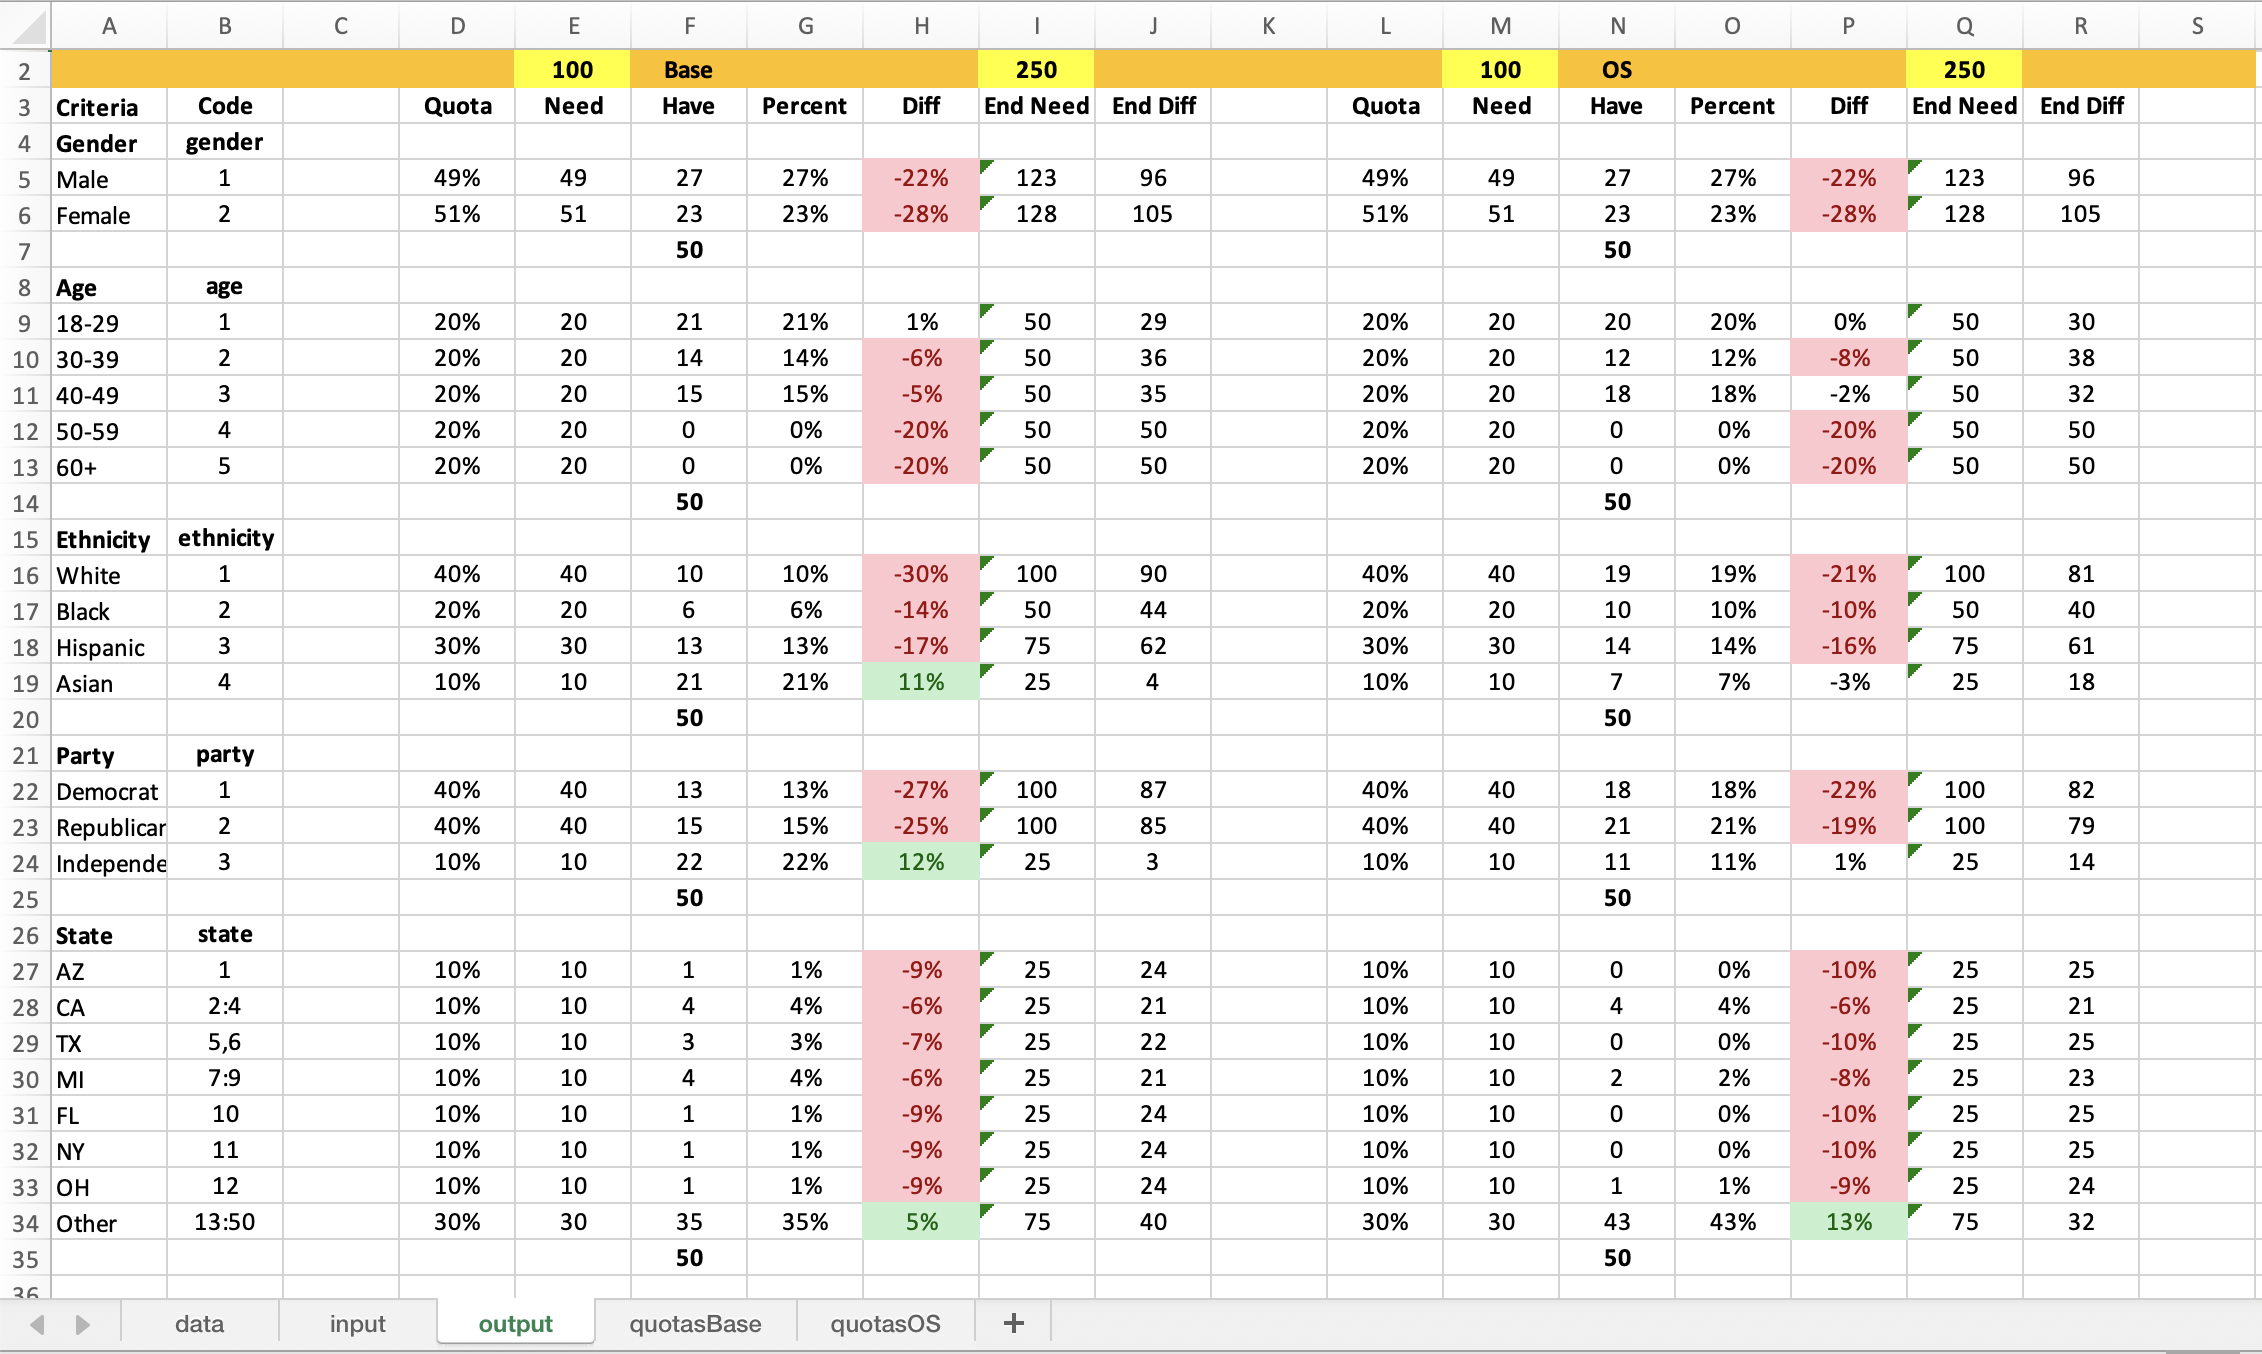